<a href="https://colab.research.google.com/github/Rhayem1920/Bitcoin-Startegy-Trading/blob/main/Optimised_Approach.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **Classification approach Optimised**

This approach consists in labeling data by adding features(that will represent targets).

These targets gives:

-1: if in the next n_hours Close prices reached actual hour's Stop loss limit first

 1: if in the next n_hours Close prices reached actual hour's Take profit limit first

 0: if in the next n_hours Close prices remained in the range of  actual hour's Take profit limit and actual hour's stop loss

 **Once our data labeled , the task will consist in supervised classification**

 **We will build classification models that wil be able in predict, given a random hour, that there will be an opportunity of TP or SL in the next n_hours**

In [2]:
!pip install mplfinance 

     |████████████████████████████████| 70 kB 3.7 MB/s 


In [3]:
# Load libraries
import matplotlib.ticker as mticker
from mplfinance.original_flavor import candlestick_ohlc
from matplotlib.dates import date2num 
from pylab import rcParams
import numpy as np
import pandas as pd
from matplotlib import pyplot
from pandas import read_csv, set_option
from pandas.plotting import scatter_matrix
import seaborn as sns
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split, KFold, cross_val_score, GridSearchCV
import matplotlib.dates as mdates

from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.stattools import adfuller

from statsmodels.tsa.arima_model import ARIMA
import statsmodels.api as sm
import statsmodels.tsa.api as smt
import statsmodels.formula.api as smf
# models for classification:
#Simple classifiers:
from sklearn.svm import SVC 
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.naive_bayes import GaussianNB
from sklearn.svm import SVC
from sklearn.neural_network import MLPClassifier
from sklearn.pipeline import Pipeline
# ensemble learning classification models:
from sklearn.ensemble import AdaBoostClassifier, GradientBoostingClassifier, RandomForestClassifier, ExtraTreesClassifier
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
# Deep Learning Models: Neural Networks
from keras.models import Sequential
from keras.layers import Dense
from keras.wrappers.scikit_learn import KerasClassifier
from tensorflow.keras.optimizers import SGD

try:
    import xgboost
except ImportError as ex:
    print("Error: the xgboost library is not installed.")
    xgboost = None
import lightgbm as lgb

#Libraries for Saving the Model
from pickle import dump
from pickle import load

#Libraries for Saving the Model
from pickle import dump
from pickle import load



# common libraries for data engineering and machine learning tasks
import numpy as np
import pandas as pd 
import seaborn as sns
import matplotlib as mpl
import matplotlib.pyplot as plt 
import os
# ignore warnings  
import warnings
warnings.filterwarnings('ignore')


# rectifying visualistaion's parameters to have pretty plots
font={'size': 14,
        'weight' : 'bold',
        'family':'monospace'} # weight could be book,bold etc ...
mpl.rc('font',**font)
mpl.rc('axes', labelsize=12)
mpl.rc('xtick', labelsize=12)
mpl.rc('ytick', labelsize=12)
mpl.rc('lines',linewidth=5,c='black')
plt.rcParams["figure.figsize"] = (16,9)
sns.set_style('darkgrid')


/usr/local/lib/python3.7/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


**The problem of predicting a Stop loss, Take profit or a maitain between them for a trading strategy is considered as a classification task, where the predicted variable has a value of 1 for TP , -1 for stop loss and 0 otherwise**

**The data used is representing  bitcoin exchanges in terms of average hourly
volume.The data covers prices from Jun 2021 to January 2022.**

**The dataset has hour-by-hour data of OHLC (Open, High, Low, Close) and
traded volume of bitcoin.** 

In [4]:
# connect drive and colab to get the sheets:
from google.colab import drive
drive.mount('/content/drive')
df=pd.read_csv('/content/drive/My Drive/dfi_labs_BTCUSDT-1h-spot-data.csv',sep=',')
df.drop('Unnamed: 0',axis=1,inplace=True)
df.head() 

Mounted at /content/drive


,Open,High,Low,Close,Volume,Start_time,Close_time,qav
0,37253.82,37894.81,37100.00,37798.31,5234.072735,2021-06-01 00:00:00,2021-06-01 00:59:59.999,1.969266e+08
1,37798.32,37803.49,37160.00,37196.64,3154.434156,2021-06-01 01:00:00,2021-06-01 01:59:59.999,1.181736e+08
2,37196.64,37296.08,36620.00,36850.00,3078.850158,2021-06-01 02:00:00,2021-06-01 02:59:59.999,1.135512e+08
3,36850.00,37124.09,36478.00,36704.99,3179.701359,2021-06-01 03:00:00,2021-06-01 03:59:59.999,1.169058e+08
4,36706.80,36957.69,36561.89,36748.01,1767.107527,2021-06-01 04:00:00,2021-06-01 04:59:59.999,6.497698e+07


### **Initial Inspections**

In [5]:
df.describe()

,Open,High,Low,Close,Volume,qav
count,5576.000000,5576.000000,5576.000000,5576.000000,5576.000000,5.576000e+03
mean,46766.641105,47013.738997,46508.954835,46767.551804,2249.553921,1.010929e+08
std,9511.922301,9534.347009,9485.186230,9511.270672,1889.439580,7.912213e+07
min,29239.000000,29706.830000,28805.000000,29238.990000,359.029930,1.697315e+07
25%,39490.125000,39738.055000,39195.325000,39493.335000,1198.028690,5.529316e+07
50%,46856.735000,47092.895000,46622.540000,46856.735000,1706.120281,8.041977e+07
75%,53821.072500,54177.042500,53505.250000,53821.077500,2683.493584,1.192787e+08
max,68635.120000,69000.000000,68451.190000,68633.690000,34147.483623,1.490566e+09


**The dataset is not large, with approximately 5576 total
observations.**

**---> Obviously for the "Volume" and "qav" columns ,the max and the min are very far from each other.**

**---> The mean is very far from the max which proves the skewness of the distribution.**

In [6]:
pd.DataFrame(df.skew())

,0
Open,0.230697
High,0.232004
Low,0.228681
Close,0.230613
Volume,4.724487
qav,4.537945


**---> Skewness seems high only for Volume and qav features**

In [7]:
df.dtypes

Open          float64
High          float64
Low           float64
Close         float64
Volume        float64
Start_time     object
Close_time     object
qav           float64
dtype: object

**---> No missing values in the datafarme**

## **Labelling**


**As a first step, we will create the target variable
for our model. This is the column that will indicate whether the trading signal is a Take Profit
or a stop loss or no one of both them.**

**The SL & TP signals are generated based on what is touched first**



In [8]:
# for each point, we will calculate the volaltity of the past 24hours, then define TP&SL and then indicating if it was TP or SL or between them after a predefined long period(1week,1month,3months)
def volatility(df,index):
  if index>24:
   return df['Close'][index-24:index].std() #past 24h volatility
  else:
    return df['Close'][:index].std() #  if index=10<24: past 10h volatility


list_values=[df['Close'][1]]

def Actual_index(x,df): 
  list_index=df.Close[df.Close == x].index.tolist() #list of indexes where x appeared in the dataset , i have verified that every close price may appear max 2 times in the dataset
  if len(list_index)==2:
    if x in list_values:
      index=list_index[1]
    else:
      index=list_index[0]
  else:
    index=list_index[0]
  list_values.append(x)    # save x in this list
  return index

  
df['SL_limit']=df['Close'].apply(lambda x:x-2*volatility(df,Actual_index(x,df)))
df['TP_limit']=df['Close'].apply(lambda x:x+2*volatility(df,Actual_index(x,df)))
df.head()


,Open,High,Low,Close,Volume,Start_time,Close_time,qav,SL_limit,TP_limit
0,37253.82,37894.81,37100.00,37798.31,5234.072735,2021-06-01 00:00:00,2021-06-01 00:59:59.999,1.969266e+08,NaN,NaN
1,37798.32,37803.49,37160.00,37196.64,3154.434156,2021-06-01 01:00:00,2021-06-01 01:59:59.999,1.181736e+08,NaN,NaN
2,37196.64,37296.08,36620.00,36850.00,3078.850158,2021-06-01 02:00:00,2021-06-01 02:59:59.999,1.135512e+08,35999.110126,37700.889874
3,36850.00,37124.09,36478.00,36704.99,3179.701359,2021-06-01 03:00:00,2021-06-01 03:59:59.999,1.169058e+08,35745.317162,37664.662838
4,36706.80,36957.69,36561.89,36748.01,1767.107527,2021-06-01 04:00:00,2021-06-01 04:59:59.999,6.497698e+07,35775.118403,37720.901597


In [9]:
df['SL_limit'][1],df['TP_limit'][1]=df['Close'][1],df['Close'][1]


**Depending of the dynamism of the bitcoin market, traders need algorithms to forecast TP and SL signals on short term horizons(2hours,half a day, one day ...) and sometimes on long term horizons(one week, one month, 6months , 1 year etc...)**

**Since the task supposed that we will enter in a long position at a specific hour, i made the choice to create different targets in short term horizons (half a day, 1 day, 3days, 1week, 1month) so that our algorithm could be able to forecast in different future periods based on the trader's needs**

In [10]:
def pred(list,SL_limit,TP_limit):
  cpt=0
  for e in list:
    cpt+=1
    if e>TP_limit:
      return 1
      break
    elif e<SL_limit:
      return -1
      break
    if cpt==len(list):
      return 0
      break

def two_hours_pred(df,x):
  index_x=Actual_index(x,df)
  future_prices=df['Close'][index_x+1:index_x+1+13].values.tolist() # future prices in 2 hours
  SL_limit=x-(2*volatility(df,index_x))
  TP_limit=x+(2*volatility(df,index_x))
  return pred(future_prices,SL_limit,TP_limit)
def half_day_pred(df,x):
  index_x=Actual_index(x,df)
  future_prices=df['Close'][index_x+1:index_x+1+13].values.tolist() # future prices in 12 hours
  SL_limit=x-(2*volatility(df,index_x))
  TP_limit=x+(2*volatility(df,index_x))
  return pred(future_prices,SL_limit,TP_limit)

def one_day_pred(df,x) :
  index_x=Actual_index(x,df)
  future_prices=df['Close'][index_x+1:index_x+1+24].values.tolist() # future prices in one day
  SL_limit=x-(2*volatility(df,index_x))
  TP_limit=x+(2*volatility(df,index_x))
  return pred(future_prices,SL_limit,TP_limit) 
   
def three_days_pred(df,x):
  index_x=Actual_index(x,df)
  future_prices=df['Close'][index_x+1:index_x+1+24*3].values.tolist() # future prices in three days
  SL_limit=x-(2*volatility(df,index_x))
  TP_limit=x+(2*volatility(df,index_x))
  return pred(future_prices,SL_limit,TP_limit)

def one_week_pred(df,x):
  index_x=Actual_index(x,df)
  future_prices=df['Close'][index_x+1:index_x+1+24*7].values.tolist() # future prices in one week
  SL_limit=x-(2*volatility(df,index_x))
  TP_limit=x+(2*volatility(df,index_x))
  return pred(future_prices,SL_limit,TP_limit)



df['12hour_mvt']=df['Close'].apply(lambda x:half_day_pred(df,x))
df['1day_mvt']=df['Close'].apply(lambda x:one_day_pred(df,x))
df['3days_mvt']=df['Close'].apply(lambda x:three_days_pred(df,x))
df['1week_mvt']=df['Close'].apply(lambda x:one_week_pred(df,x))

df.tail()

,Open,High,Low,Close,Volume,Start_time,Close_time,qav,SL_limit,TP_limit,12hour_mvt,1day_mvt,3days_mvt,1week_mvt
5571,41368.68,41672.39,41324.67,41573.59,1248.91310,2022-01-19 09:00:00,2022-01-19 09:59:59.999,5.185166e+07,40879.421809,42267.758191,1.0,1.0,1.0,1.0
5572,41573.59,41616.52,41290.00,41505.53,1348.84706,2022-01-19 10:00:00,2022-01-19 10:59:59.999,5.590542e+07,40803.367507,42207.692493,1.0,1.0,1.0,1.0
5573,41509.06,42178.48,41498.42,42033.00,2283.17846,2022-01-19 11:00:00,2022-01-19 11:59:59.999,9.568382e+07,41320.010209,42745.989791,0.0,0.0,0.0,0.0
5574,42033.00,42272.71,41893.62,42094.99,1326.28832,2022-01-19 12:00:00,2022-01-19 12:59:59.999,5.583631e+07,41376.421784,42813.558216,0.0,0.0,0.0,0.0
5575,42094.99,42332.07,42081.66,42293.85,495.82709,2022-01-19 13:00:00,2022-01-19 13:59:59.999,2.093807e+07,41566.545112,43021.154888,NaN,NaN,NaN,NaN


In [11]:
df['12hour_mvt'][5575],df['1day_mvt'][5575],df['3days_mvt'][5575],df['1week_mvt'][5575]=0,0,0,0


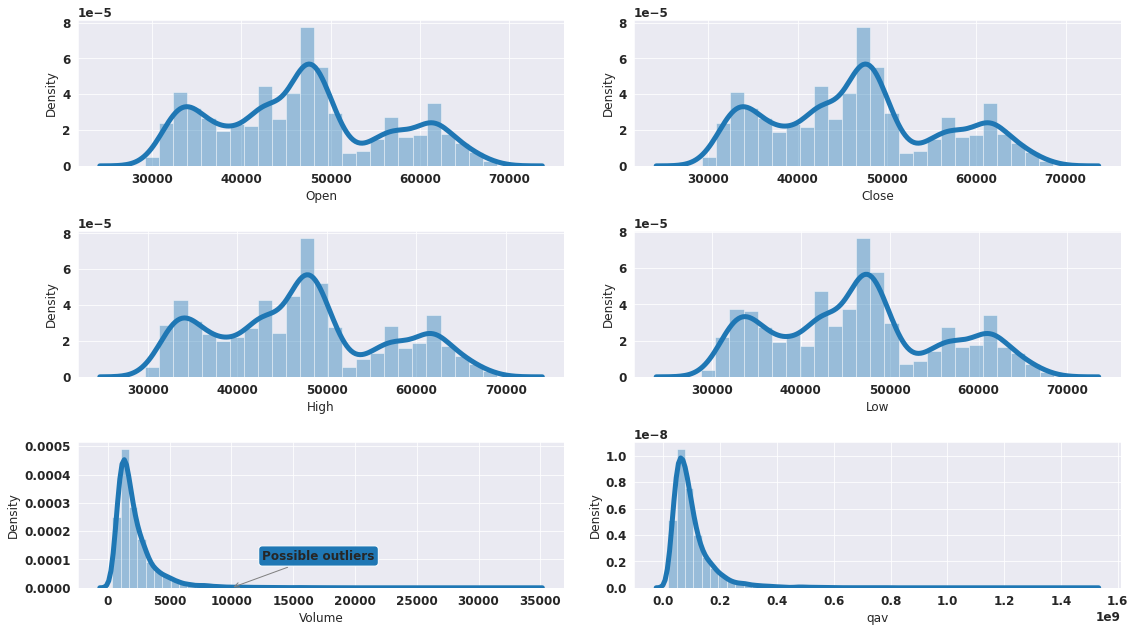

In [12]:
n_rows=3
n_cols=2
col = ['Open','Close','High','Low','Volume','qav']
fig, axes = plt.subplots(nrows=n_rows, ncols=n_cols)
cpt=0
rcParams['figure.figsize'] = 14,6
for i, column in enumerate(col):
    cpt+=1
    ax=sns.distplot(df[column],ax=axes[i//n_cols,i%n_cols])
    if cpt==5:
      ax.annotate('Possible outliers', xy=(10000,0.0), xytext=(12500,0.0001), fontsize=12,
                arrowprops=dict(arrowstyle='->', ec='grey'), bbox = dict(boxstyle="round"))
   
plt.tight_layout()


**The distribution for volume & qav features show some values that seem to be outilers since they are so far away from the first curve.**

### **Detecting & Removing Outliers**

---> Garbage in means garbage out: so w have to handle the problem of outliers 
to avoid that our models learn from them and then become biased

Text(0.5, 1.0, 'Anomaly Detection:Volume')

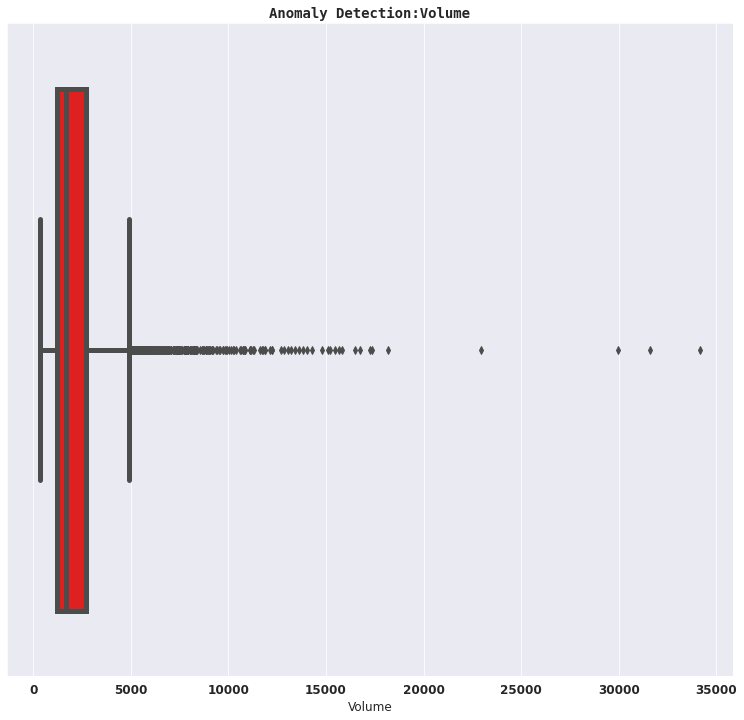

In [13]:
plt.rcParams["figure.figsize"] = (13,12)
sns.boxplot(df['Volume'],color='red',data=df)
plt.title('Anomaly Detection:Volume',fontdict=font)


Text(0.5, 1.0, 'Anomaly Detection:QAV')

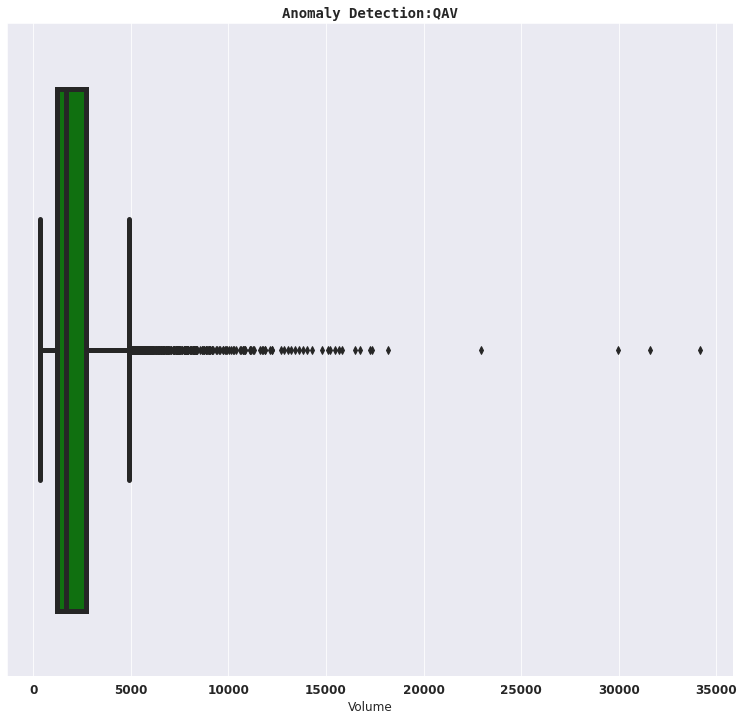

In [14]:
sns.boxplot(df['Volume'],color='green',data=df)
plt.title('Anomaly Detection:QAV',fontdict=font)

### **Removing Outliers using IQR method:**


In [15]:
def remove_outliers(df):
 Q1 = df.quantile(0.25)
 Q3 = df.quantile(0.75)
 IQR = Q3 - Q1
 df = df[~((df < (Q1 - 1.5 * IQR)) |(df > (Q3 + 1.5 * IQR))).any(axis=1)]
 return df

In [16]:
print(df.shape)
df=remove_outliers(df)
print(df.shape)

(5576, 14)
(5132, 14)


## **Adding 2hours_mvt Target**

**It's so crucial to have this target since the market is rising (long position) 
and our model should be able to predict TP & SL signals in the next 2 hours**


In [17]:
df['2hours_mvt']=df['Close'].apply(lambda x:two_hours_pred(df,x))


In [18]:
df['2hours_mvt'].isna().sum()

436

**I have verified that with KNN imputer, all nan values will be replaced by float that are really closed to zero**

**ThereFore all nan values here will be filled by 0**

In [19]:
df['2hours_mvt'] = df['2hours_mvt'].fillna(0)
df['2hours_mvt'].value_counts()

-1.0    2396
 1.0    1901
 0.0     835
Name: 2hours_mvt, dtype: int64

### **Feature Enginnering**

##### **Adding Financial indicators features(momentum & trend)**


  
  **The current data of the bitcoin consists of date, open, high, low, close, and volume.**

**The task here is 
to identify and construct new features that may capture the risks or characteristics
embodied by these features and give more patterns for the algorithms.**

**For this case study, we will explore the efficacy of
specific momentum technical indicators.**

**Moving average:**
A moving average provides an indication of a price trend by cutting down the
amount of noise in the series.


**Stochastic oscillator %K:**
A stochastic oscillator is a momentum indicator that compares the closing price
of a security to a range of its previous prices over a certain period of time. %K
and %D are slow and fast indicators. The fast indicator is more sensitive than the
slow indicator to changes in the price of the underlying security and will likely
result in many transaction signals.


**Relative strength index (RSI):**
This is a momentum indicator that measures the magnitude of recent price
changes to evaluate overbought or oversold conditions in the price of a stock or
other asset. The RSI ranges from 0 to 100. An asset is deemed to be overbought
once the RSI approaches 70, meaning that the asset may be getting overvalued
and is a good candidate for a pullback. Likewise, if the RSI approaches 30, it is an
indication that the asset may be getting oversold and is therefore likely to become
undervalued.


**Rate of change (ROC):**
This is a momentum oscillator that measures the percentage change between the
current price and the n period past prices. Assets with higher ROC values are
considered more likely to be overbought; those with lower ROC, more likely to
be oversold.


**Momentum (MOM):**
This is the rate of acceleration of a security’s price or volume—that is, the speed
at which the price is changing.

In [20]:
# Adding OHLC average to detect more patterns
df['ohlc_average'] = (df['Open'] + df['High'] + df['Low'] + df['Close']) / 4

#calculation of exponential moving average
def EMA(df, n):
    EMA = pd.Series(df['Close'].ewm(span=n, min_periods=n).mean(), name='EMA_' + str(n))
    return EMA
df['EMA12_hour'] = EMA(df, 12)
df['EMA24_hour'] = EMA(df, 24)

#calculation of rate of change
def ROC(df, n):  
    M = df.diff(n - 1)  
    N = df.shift(n - 1)  
    ROC = pd.Series(((M / N) * 100), name = 'ROC_' + str(n))   
    return ROC
df['ROC12_hou'] = ROC(df['Close'], 12)
df['ROC24_hour'] = ROC(df['Close'], 24)

#Calculation of price momentum
def MOM(df, n):   
    MOM = pd.Series(df.diff(n), name='Momentum_' + str(n))   
    return MOM
df['MOM12_hour'] = MOM(df['Close'], 12)
df['MOM24_hour'] = MOM(df['Close'], 24)

#calculation of relative strength index
def RSI(series, period):
 delta = series.diff().dropna()
 u = delta * 0
 d = u.copy()
 u[delta > 0] = delta[delta > 0]
 d[delta < 0] = -delta[delta < 0]
 u[u.index[period-1]] = np.mean( u[:period] ) #first value is sum of avg gains
 u = u.drop(u.index[:(period-1)])
 d[d.index[period-1]] = np.mean( d[:period] ) #first value is sum of avg losses
 d = d.drop(d.index[:(period-1)])
 rs = u.ewm(com=period-1, adjust=False).mean() / \
 d.ewm(com=period-1, adjust=False).mean()
 return 100 - 100 / (1 + rs)
df['RSI12_hour'] = RSI(df['Close'], 12)
df['RSI24_hour'] = RSI(df['Close'], 24)

#calculation of stochastic osillator.

def STOK(close, low, high, n): 
 STOK = ((close - low.rolling(n).min()) / (high.rolling(n).max() - low.rolling(n).min())) * 100
 return STOK

def STOD(close, low, high, n):
 STOK = ((close - low.rolling(n).min()) / (high.rolling(n).max() - low.rolling(n).min())) * 100
 STOD = STOK.rolling(3).mean()
 return STOD

df['%K12_hour'] = STOK(df['Close'], df['Low'], df['High'], 12)
df['%D12_hour'] = STOD(df['Close'], df['Low'], df['High'], 12)
df['%K24_hour'] = STOK(df['Close'], df['Low'], df['High'], 24)
df['%D24_hour'] = STOD(df['Close'], df['Low'], df['High'], 24)


#Calculation of moving average
def MA(df, n):
    MA = pd.Series(df['Close'].rolling(n, min_periods=n).mean(), name='MA_' + str(n))
    return MA
df['MA12_hour'] = MA(df, 12)

df.tail()


,Open,High,Low,Close,Volume,Start_time,Close_time,qav,SL_limit,TP_limit,...,ROC24_hour,MOM12_hour,MOM24_hour,RSI12_hour,RSI24_hour,%K12_hour,%D12_hour,%K24_hour,%D24_hour,MA12_hour
5571,41368.68,41672.39,41324.67,41573.59,1248.91310,2022-01-19 09:00:00,2022-01-19 09:59:59.999,5.185166e+07,40879.421809,42267.758191,...,-0.837525,-796.33,-329.89,42.803300,43.466497,28.022339,17.025097,28.022339,17.025097,41913.395000
5572,41573.59,41616.52,41290.00,41505.53,1348.84706,2022-01-19 10:00:00,2022-01-19 10:59:59.999,5.590542e+07,40803.367507,42207.692493,...,-0.832916,-975.43,-419.19,41.324270,42.670442,25.800260,22.881905,23.638273,22.161243,41832.109167
5573,41509.06,42178.48,41498.42,42033.00,2283.17846,2022-01-19 11:00:00,2022-01-19 11:59:59.999,9.568382e+07,41320.010209,42745.989791,...,0.539329,-319.12,178.86,54.590343,50.066047,65.698084,39.840228,57.615109,36.425240,41805.515833
5574,42033.00,42272.71,41893.62,42094.99,1326.28832,2022-01-19 12:00:00,2022-01-19 12:59:59.999,5.583631e+07,41376.421784,42813.558216,...,1.058479,-157.74,287.47,55.869533,50.843692,70.251352,53.916565,61.608178,47.620520,41792.370833
5575,42094.99,42332.07,42081.66,42293.85,495.82709,2022-01-19 13:00:00,2022-01-19 13:59:59.999,2.093807e+07,41566.545112,43021.154888,...,2.037451,-126.33,639.76,59.829638,53.279283,84.857945,73.602460,74.417691,64.546993,41781.843333


### **Dealing With Missing Values in New features**

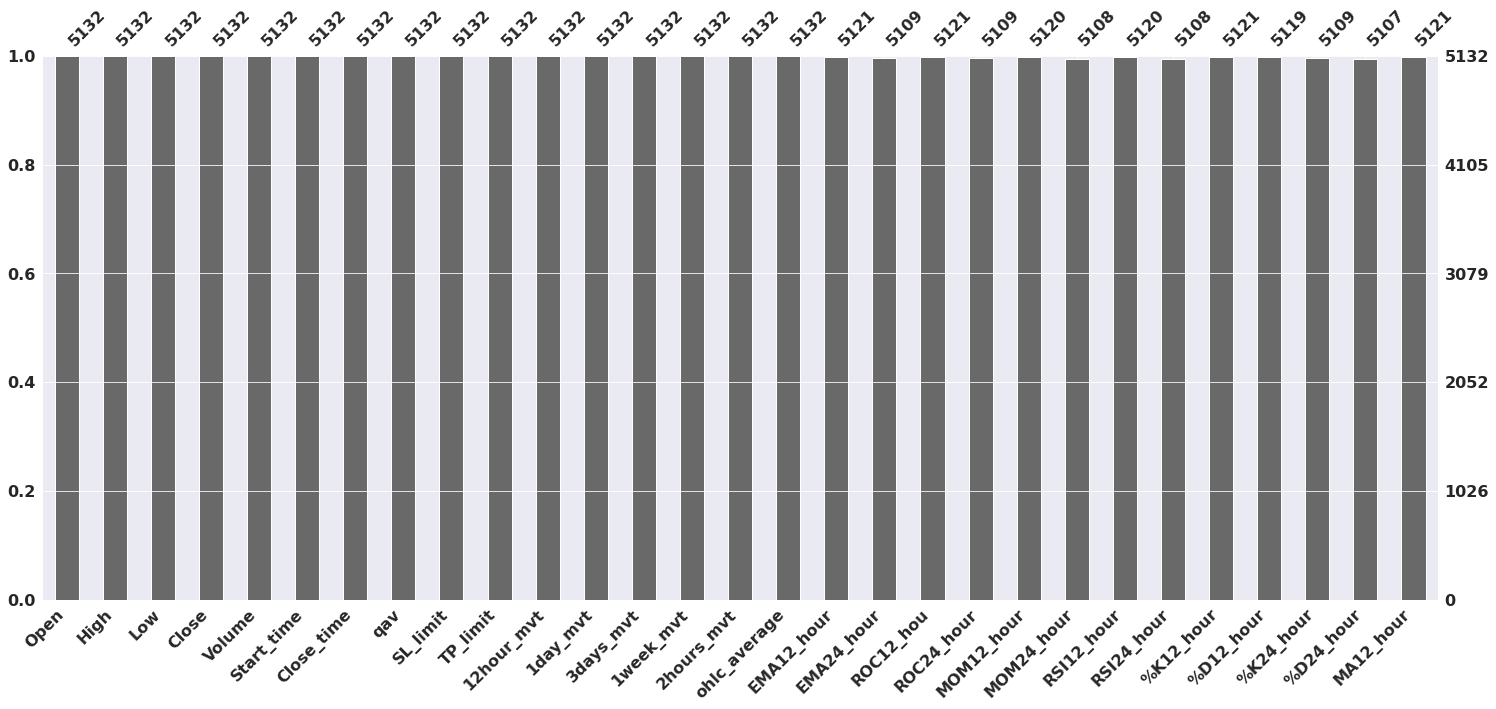

In [21]:
plt.figure(figsize=(6,6))
import missingno as msno
msno.bar(df)

### **KNN imputing for missing values in new features**

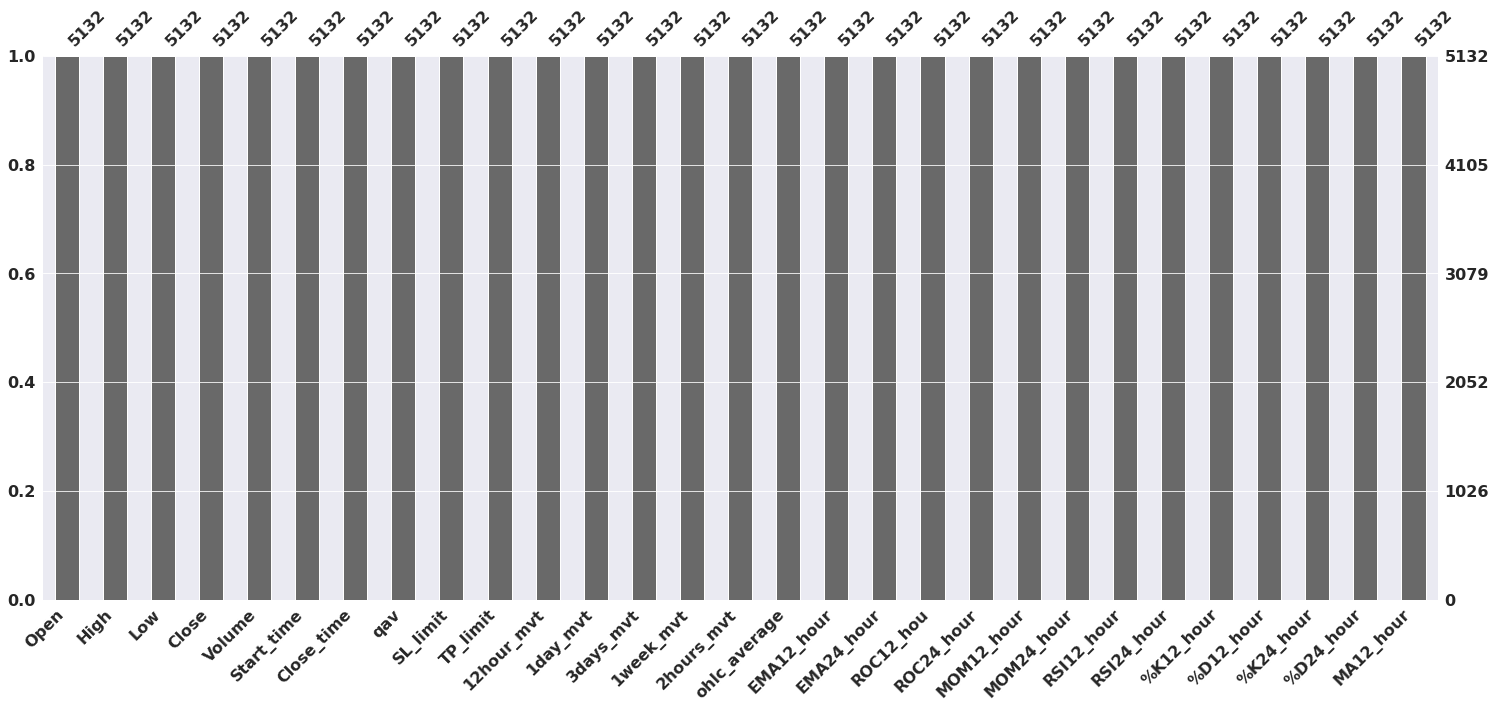

In [22]:
from sklearn.impute import KNNImputer

new_features=df.columns.tolist()[16:] #only new created features
for col in new_features:
 knn_imputer = KNNImputer(n_neighbors=5)
 df[col] = knn_imputer.fit_transform(df[[col]])
msno.bar(df)

## **Visualisation & Data Exploration**


**Extract YY-MM-DD date** 


In [23]:
df['Start_time'] = pd.to_datetime(df['Start_time'])
df['Date_mpl'] = df['Start_time'].dt.date
df['Year'] = df['Start_time'].dt.year
df['Month'] = df['Start_time'].dt.month
df['Day'] = df['Start_time'].dt.day
df['Hour'] = df['Start_time'].dt.time

In [24]:
df.drop(columns = ['Close_time'],inplace = True)

In [25]:
df.head(3)

,Open,High,Low,Close,Volume,Start_time,qav,SL_limit,TP_limit,12hour_mvt,...,%K12_hour,%D12_hour,%K24_hour,%D24_hour,MA12_hour,Date_mpl,Year,Month,Day,Hour
1,37798.32,37803.49,37160.0,37196.64,3154.434156,2021-06-01 01:00:00,1.181736e+08,37196.640000,37196.640000,0.0,...,51.829825,51.828507,52.133674,52.134047,47008.056695,2021-06-01,2021,6,1,01:00:00
2,37196.64,37296.08,36620.0,36850.00,3078.850158,2021-06-01 02:00:00,1.135512e+08,35999.110126,37700.889874,0.0,...,51.829825,51.828507,52.133674,52.134047,47008.056695,2021-06-01,2021,6,1,02:00:00
3,36850.00,37124.09,36478.0,36704.99,3179.701359,2021-06-01 03:00:00,1.169058e+08,35745.317162,37664.662838,0.0,...,51.829825,51.828507,52.133674,52.134047,47008.056695,2021-06-01,2021,6,1,03:00:00


**Plot the closing price distribution of Bitcoin**


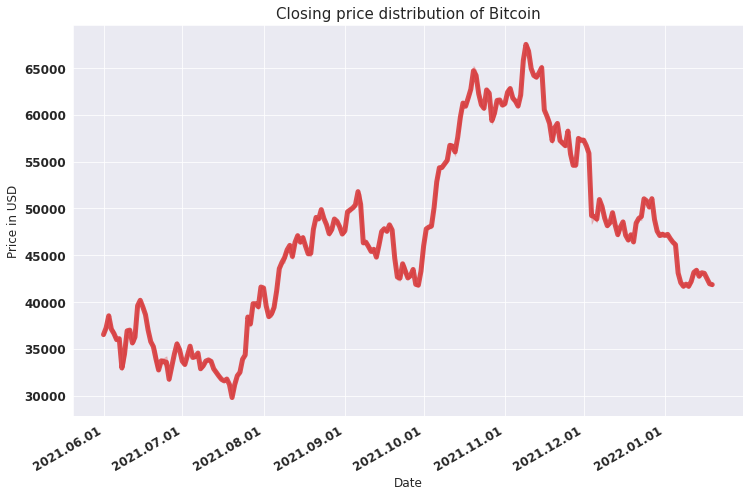

In [26]:
import matplotlib.dates as mdates
color = sns.color_palette()
#df['Date_mpl'] = df['Start_time'].dt.date
fig, ax = plt.subplots(figsize=(12,8))
sns.lineplot(x= df['Date_mpl'].values,y = df.Close.values, alpha=0.8, color=color[3], ax=ax)
ax.xaxis.set_major_locator(mdates.AutoDateLocator())
ax.xaxis.set_major_formatter(mdates.DateFormatter('%Y.%m.%d'))
fig.autofmt_xdate()
plt.xlabel('Date', fontsize=12)
plt.ylabel('Price in USD', fontsize=12)
plt.title("Closing price distribution of Bitcoin", fontsize=15)
plt.show()

**As usual, the prices of bitcoin shows a high volatilty which make our task of prediction harder**

**There was a decrease of prices during the summer(June , July, August) which justified the increase in BTC Volume daily exchanged.**

**In November,we had that famous high increase in Bitcoin Prices and the market took a short position since the volume of btc exhanged decreased as a consequence of this high suddenly increase**

**Visualuzing long and short positions using candlestick chart**


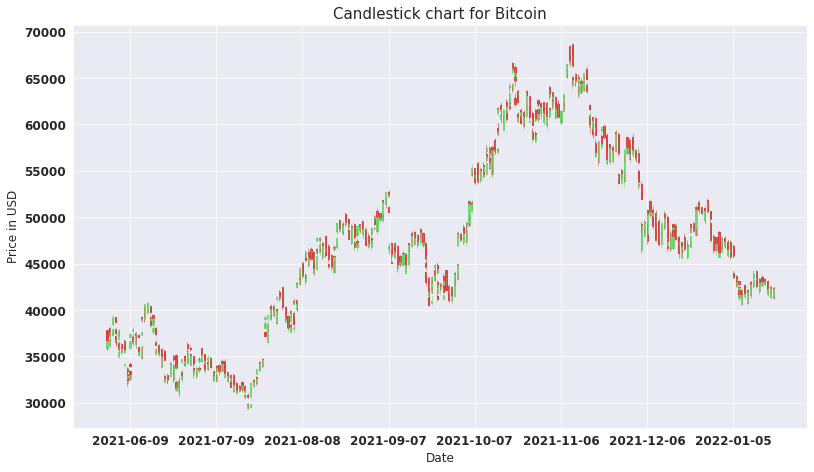

In [27]:
      
fig = plt.figure(figsize=(12,8))
ax1 = plt.subplot2grid((1,1), (0,0))
df['num_date'] = df['Date_mpl'].apply(date2num)
ohlc = []
for ind, row in df.iterrows():
    ol = [row['num_date'],row['Open'], row['High'], row['Low'], row['Close'], row['Volume']]
    ohlc.append(ol)
    
candlestick_ohlc(ax1, ohlc, width=0.4, colorup='#77d879', colordown='#db3f3f')
ax1.xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m-%d'))
ax1.xaxis.set_major_locator(mticker.MaxNLocator(10))

plt.xlabel("Date", fontsize=12)
plt.ylabel("Price in USD", fontsize=12)
plt.title("Candlestick chart for Bitcoin", fontsize=15)
plt.subplots_adjust(left=0.09, bottom=0.20, right=0.94, top=0.90, wspace=0.2, hspace=0)
plt.show()

**The uptrend in November is clear in this candlestick chart with the density of Bullish Hammer (red boxplots) in this period.**


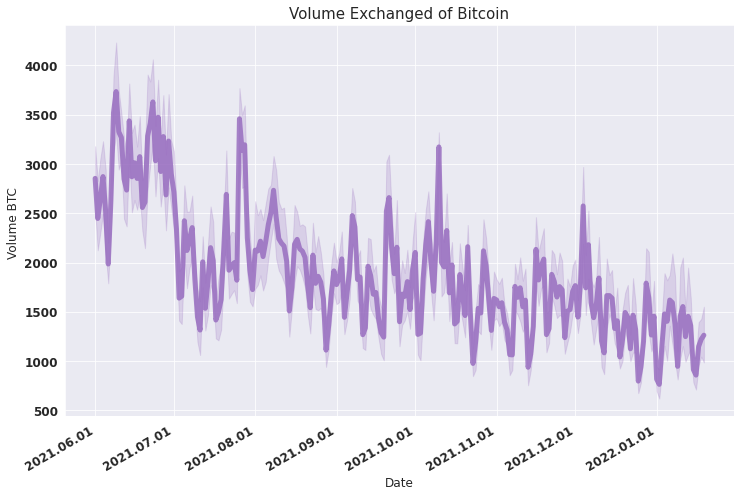

In [28]:
fig, ax = plt.subplots(figsize=(12,8))
sns.lineplot(x= df['Date_mpl'].values,y = df.Volume.values, alpha=0.8, color=color[4], ax=ax)
ax.xaxis.set_major_locator(mdates.AutoDateLocator())
ax.xaxis.set_major_formatter(mdates.DateFormatter('%Y.%m.%d'))
fig.autofmt_xdate()
plt.xlabel('Date', fontsize=12)
plt.ylabel('Volume BTC ', fontsize=12)
plt.title("Volume Exchanged of Bitcoin", fontsize=15)
plt.show() 

**Dropping High, Low, Open Features since they are very correlated to Close & OHLC_avg Features**

In [29]:
df.drop(['High','Low','Open'], axis=1,inplace=True)


## **Checking for Stationarity**

**Resampling data 'Hourly'**

In [30]:
df_hourly = df[['Start_time','Close']].set_index('Start_time')
df_hourly.index = pd.to_datetime(df_hourly.index)

In [31]:
#df_monthly = df_monthly.resample('M').mean()
df_hourly.resample('H').sum()

,Close
Start_time,
2021-06-01 01:00:00,37196.64
2021-06-01 02:00:00,36850.00
2021-06-01 03:00:00,36704.99
2021-06-01 04:00:00,36748.01
2021-06-01 05:00:00,37266.55
...,...
2022-01-19 09:00:00,41573.59
2022-01-19 10:00:00,41505.53
2022-01-19 11:00:00,42033.00


**Seasonal decomposition to identify seasonality and trends**


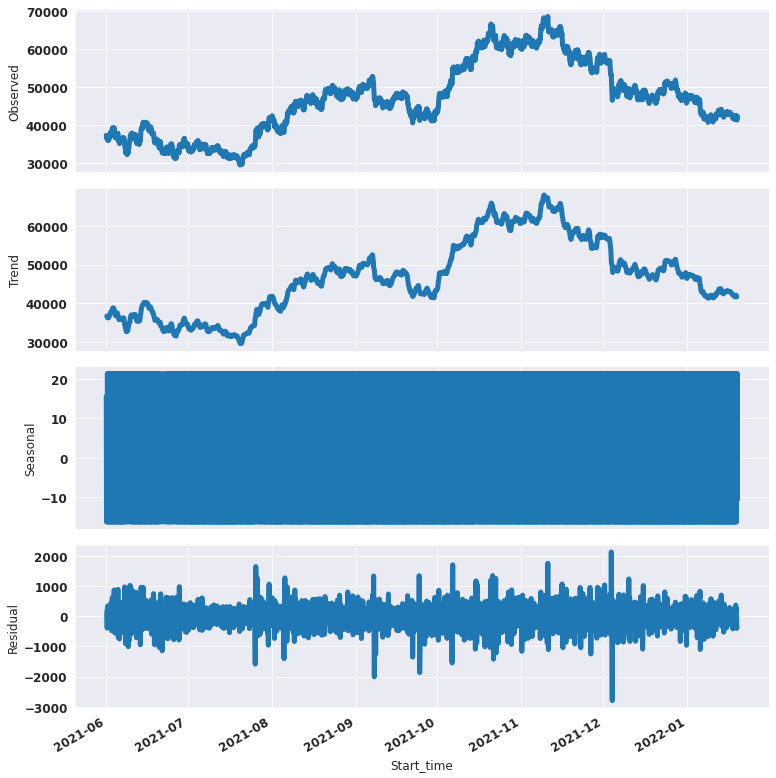

In [32]:
rcParams['figure.figsize'] = 11, 11
decomposed = seasonal_decompose(df_hourly.Close,freq=10)
figure = decomposed.plot()
plt.show()

**We can easily detect a trend in our time series especially in november where the price of bitcoin had made its popular rise**

**This trend shows clearly that our time series is not stationary**

**No seasonality observed**

**The residuals seems like white noise**

In [33]:
#drop useless features:
df.drop(['Start_time','Date_mpl', 'Year', 'Month', 'Day', 'Hour',
       'num_date'],axis=1,inplace=True)

##  **Checking Stationarity**

"Using non-stationary time series data in financial models produces unreliable and spurious results and leads to poor understanding and forecasting. We need to to transform the time series data so it becomes stationary."

In [34]:
def is_stationarity(timeseries):    
    dftest = adfuller(timeseries, autolag='AIC')
    
    dfoutput = pd.Series(dftest[0:3], index=['Test Statistic', 'p-value', 
                                             'Number of Observations Used'])
    
    for key, value in dftest[4].items():
        dfoutput['Critical Value (%s)'%key] = value
    
    print(dfoutput)

In [35]:
for col in df.columns:
  print(col+'/n',is_stationarity(df[col]))

Test Statistic                -1.499123
p-value                        0.533945
Number of Observations Used    0.000000
Critical Value (1%)           -3.431625
Critical Value (5%)           -2.862103
Critical Value (10%)          -2.567070
dtype: float64
Close/n None
Test Statistic                 -5.537838
p-value                         0.000002
Number of Observations Used    23.000000
Critical Value (1%)            -3.431631
Critical Value (5%)            -2.862106
Critical Value (10%)           -2.567071
dtype: float64
Volume/n None
Test Statistic                -6.464831e+00
p-value                        1.413726e-08
Number of Observations Used    2.300000e+01
Critical Value (1%)           -3.431631e+00
Critical Value (5%)           -2.862106e+00
Critical Value (10%)          -2.567071e+00
dtype: float64
qav/n None
Test Statistic                 -1.623020
p-value                         0.471147
Number of Observations Used    20.000000
Critical Value (1%)            -3.431630
Cri

**Based on p_value given after adf_test,non_stationary_features are ['Close','SL_limit','TP_limit','ohlc_average', 'EMA12_hour', 'EMA24_hour','MA12_hour']**


**For these Features, test Statistic value is greater than critical value , so the Time Series is Non-Staionary.This confirm the conclusion made after checking the trend and seasonality of the time series**

# **Stationarity Transformation**

**We will try to apply the differencial log to the Close time series and make sure that this technic could return a stationary one**

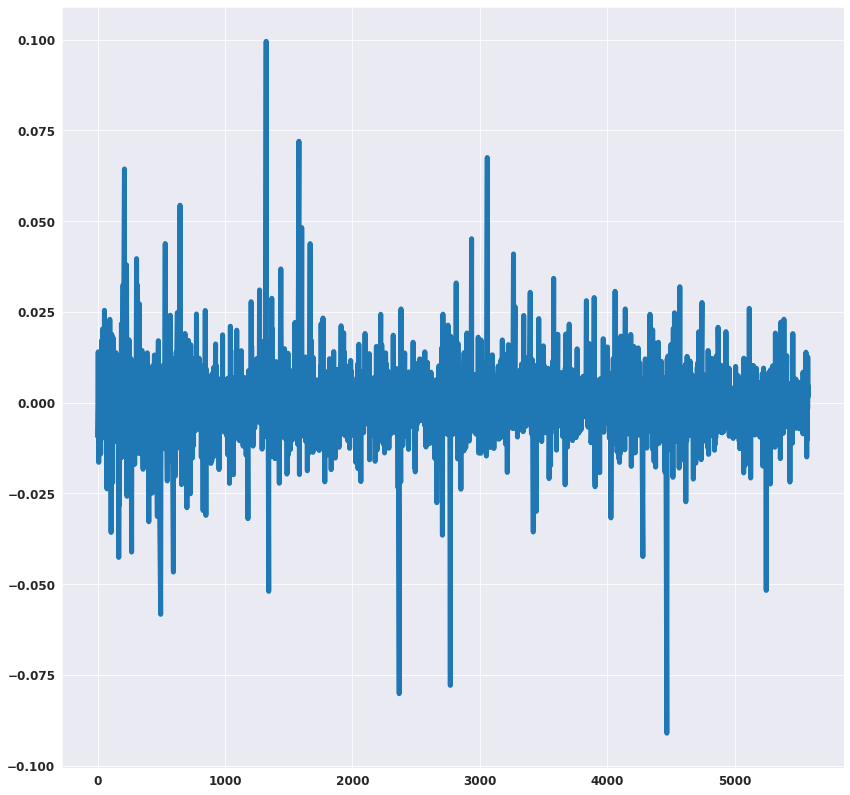

In [36]:
transformed_df = pd.Series(np.log(df["Close"])).diff().dropna()

transformed_df.plot(figsize=(14, 14));

In [37]:
results = adfuller(transformed_df)
results[1]

0.0

With a p-value < 0.01 and with the support of the graph above, we can now treat the data as a stationary time series

## **Log Differenciation for all non stationary features**

In [38]:
non_stationary_cols=['Close','SL_limit','TP_limit','ohlc_average', 'EMA12_hour', 'EMA24_hour','MA12_hour']

for col in non_stationary_cols:

 df['log_'+col] = pd.Series(np.log(df[col])).diff().dropna()


df.drop(non_stationary_cols,axis=1,inplace=True)

In [39]:
df.head()

,Volume,qav,12hour_mvt,1day_mvt,3days_mvt,1week_mvt,2hours_mvt,ROC12_hou,ROC24_hour,MOM12_hour,...,%D12_hour,%K24_hour,%D24_hour,log_Close,log_SL_limit,log_TP_limit,log_ohlc_average,log_EMA12_hour,log_EMA24_hour,log_MA12_hour
1,3154.434156,1.181736e+08,0.0,0.0,0.0,0.0,0.0,0.059517,0.126009,11.87493,...,51.828507,52.133674,52.134047,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,3078.850158,1.135512e+08,0.0,-1.0,-1.0,-1.0,-1.0,0.059517,0.126009,11.87493,...,51.828507,52.133674,52.134047,-0.009363,-0.032724,0.013465,-0.013398,0.0,0.0,0.0
3,3179.701359,1.169058e+08,0.0,0.0,1.0,1.0,1.0,0.059517,0.126009,11.87493,...,51.828507,52.133674,52.134047,-0.003943,-0.007075,-0.000961,-0.005460,0.0,0.0,0.0
4,1767.107527,6.497698e+07,0.0,0.0,1.0,1.0,-1.0,0.059517,0.126009,11.87493,...,51.828507,52.133674,52.134047,0.001171,0.000833,0.001492,-0.001242,0.0,0.0,0.0
5,2603.445266,9.653784e+07,-1.0,-1.0,-1.0,-1.0,-1.0,0.059517,0.126009,11.87493,...,51.828507,52.133674,52.134047,0.014012,0.016074,0.012052,0.007460,0.0,0.0,0.0


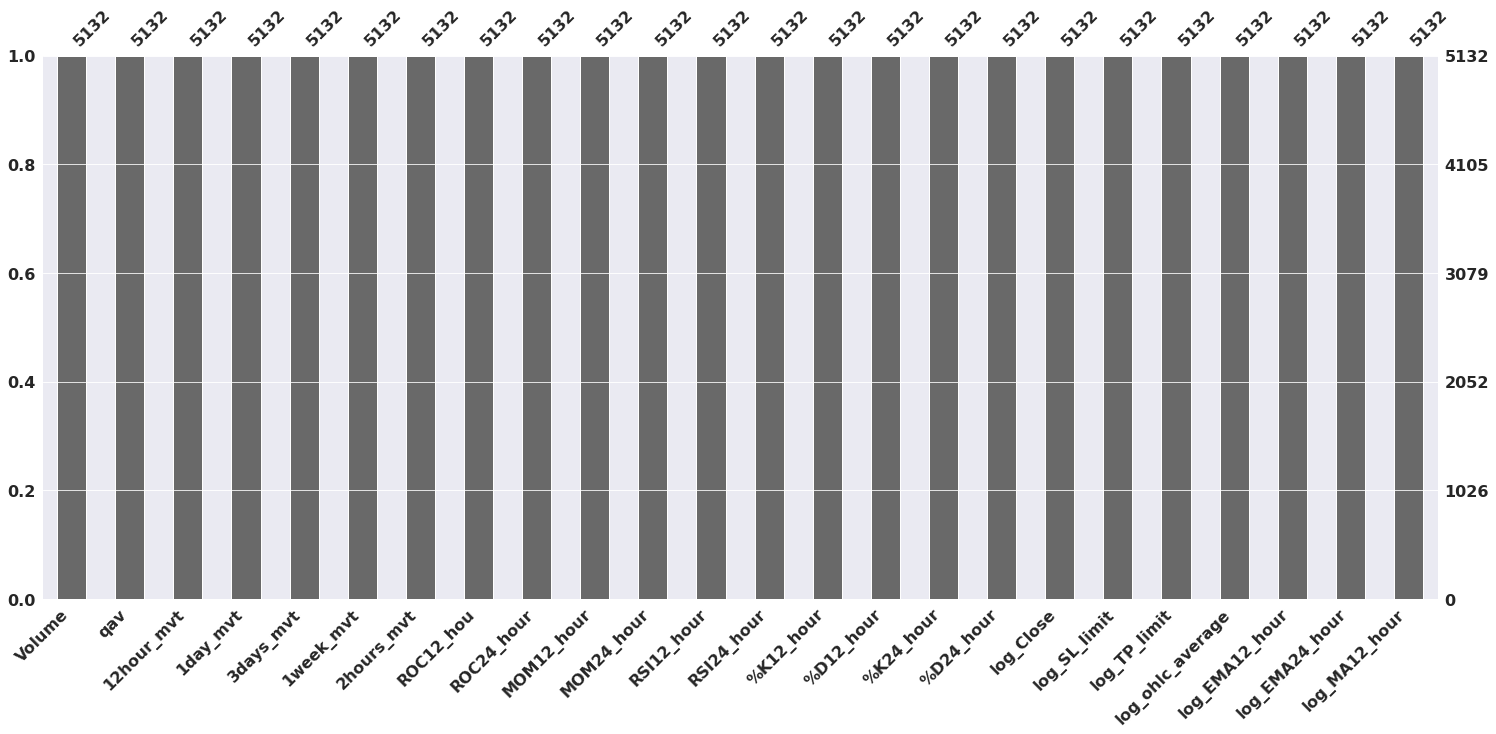

In [40]:
## we will use KNN imputing to handle missing values in new created features:


from sklearn.impute import KNNImputer

new_features=df.columns.tolist()[17:] # only new features(log transformation)
for col in new_features:
 knn_imputer = KNNImputer(n_neighbors=5)
 df[col] = knn_imputer.fit_transform(df[[col]])
msno.bar(df)

# **Autocorrelation Analysis**

How does the past observations influence the current ones?

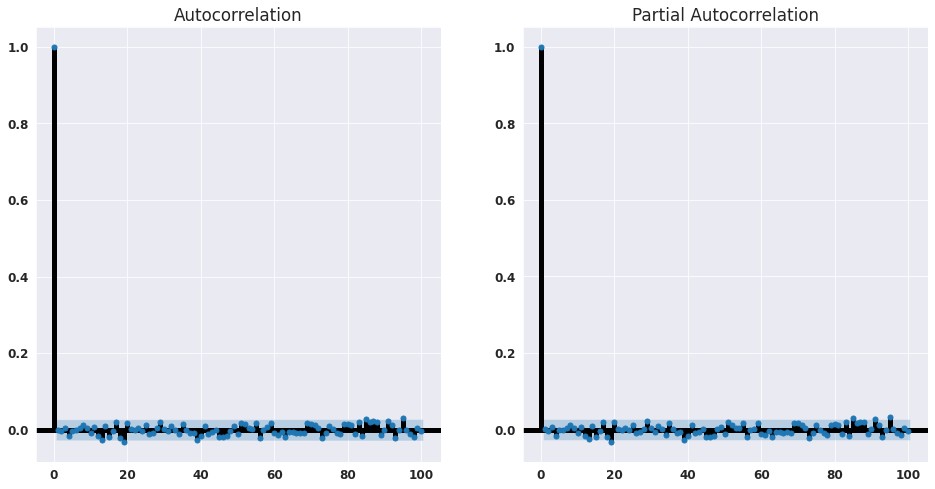

In [41]:
from statsmodels.graphics.tsaplots import plot_acf
from statsmodels.graphics.tsaplots import plot_pacf

f, ax = plt.subplots(nrows=1, ncols=2, figsize=(16, 8))

plot_acf(df['log_Close'], lags=100, ax=ax[0])
plot_pacf(df['log_Close'], lags=100, ax=ax[1])

plt.show()

**ACF, and PACF lags plots that all lags are in the Confidence interval, and therefore, the correlation is so weak and the time series is stationary**

**Depending on these two plots, these time series behaves like an ARMA(1,0)**

## **Checking Final Dataset(Features Distribution, Correlation,...)**

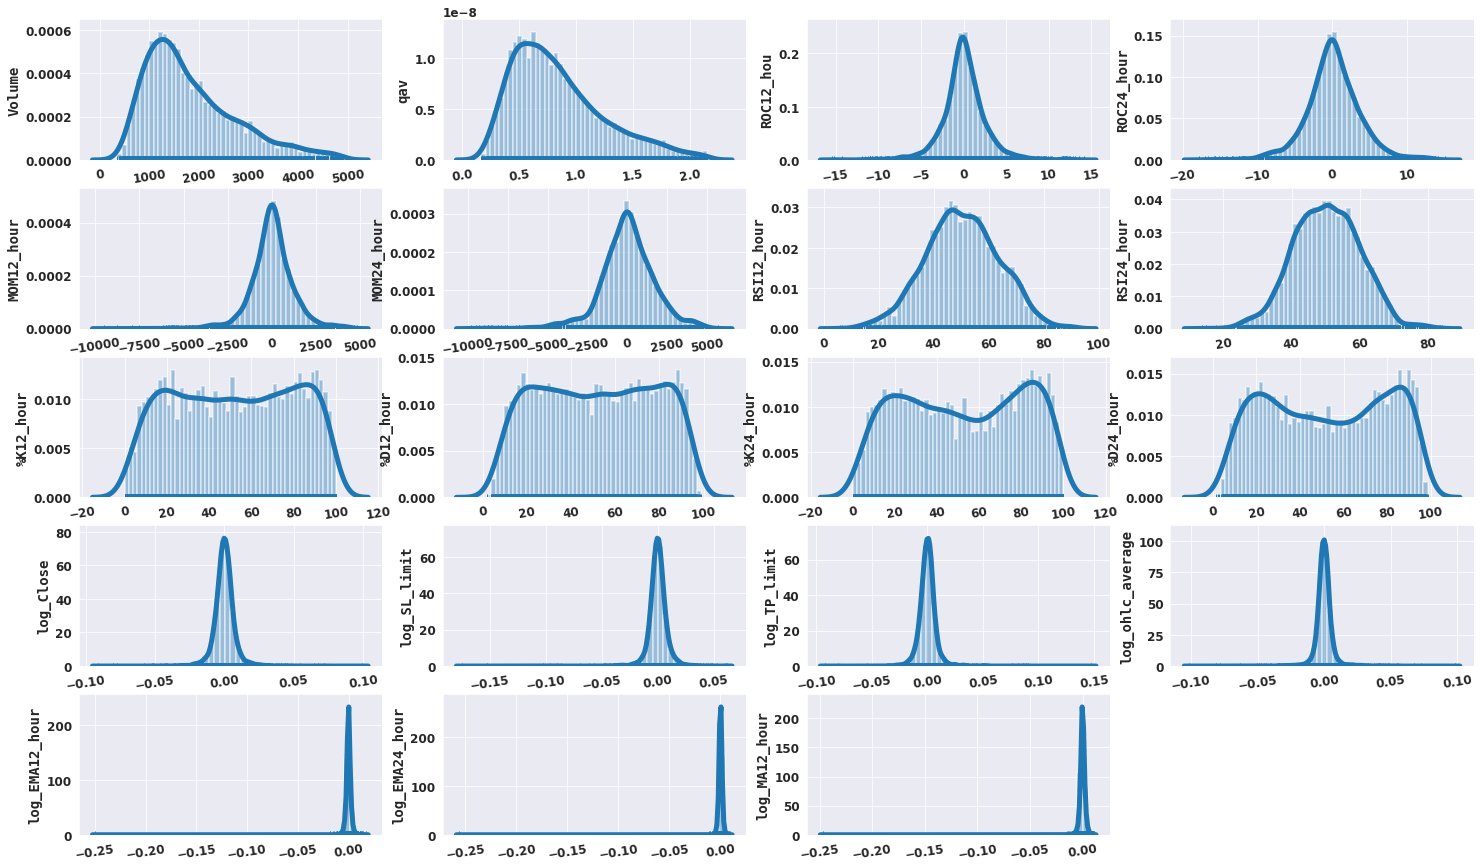

<Figure size 1800x1080 with 0 Axes>

In [42]:
# plot feature's histtplot
def graphe(feature):
    with sns.axes_style('darkgrid'):
        ax=sns.distplot(x=df[feature],hist=True,rug=True, hist_kws={"linewidth": 2,"edgecolor":'w'},kde_kws={'linewidth':5},bins=50)
        plt.ylabel(feature,fontsize=14,fontdict=font)
        plt.xlabel(xlabel=None)
        plt.xticks(rotation=9)
        plt.grid(b=True)
features=df.columns.tolist()
targets=['12hour_mvt',
 '1day_mvt',
 '3days_mvt',
 '1week_mvt',
 '2hours_mvt',]
features_to_display=[feature for feature in features if not(feature in targets)]
plt.rcParams["figure.figsize"] = (25,15)

for i in range(1,20):
    plt.subplot(5,4,i)
    graphe(features_to_display[i-1])
    
plt.figure(facecolor='grey',edgecolor='black')
plt.subplots_adjust(left=None, bottom=None, right=None, top=None,wspace=25,
    hspace=35)

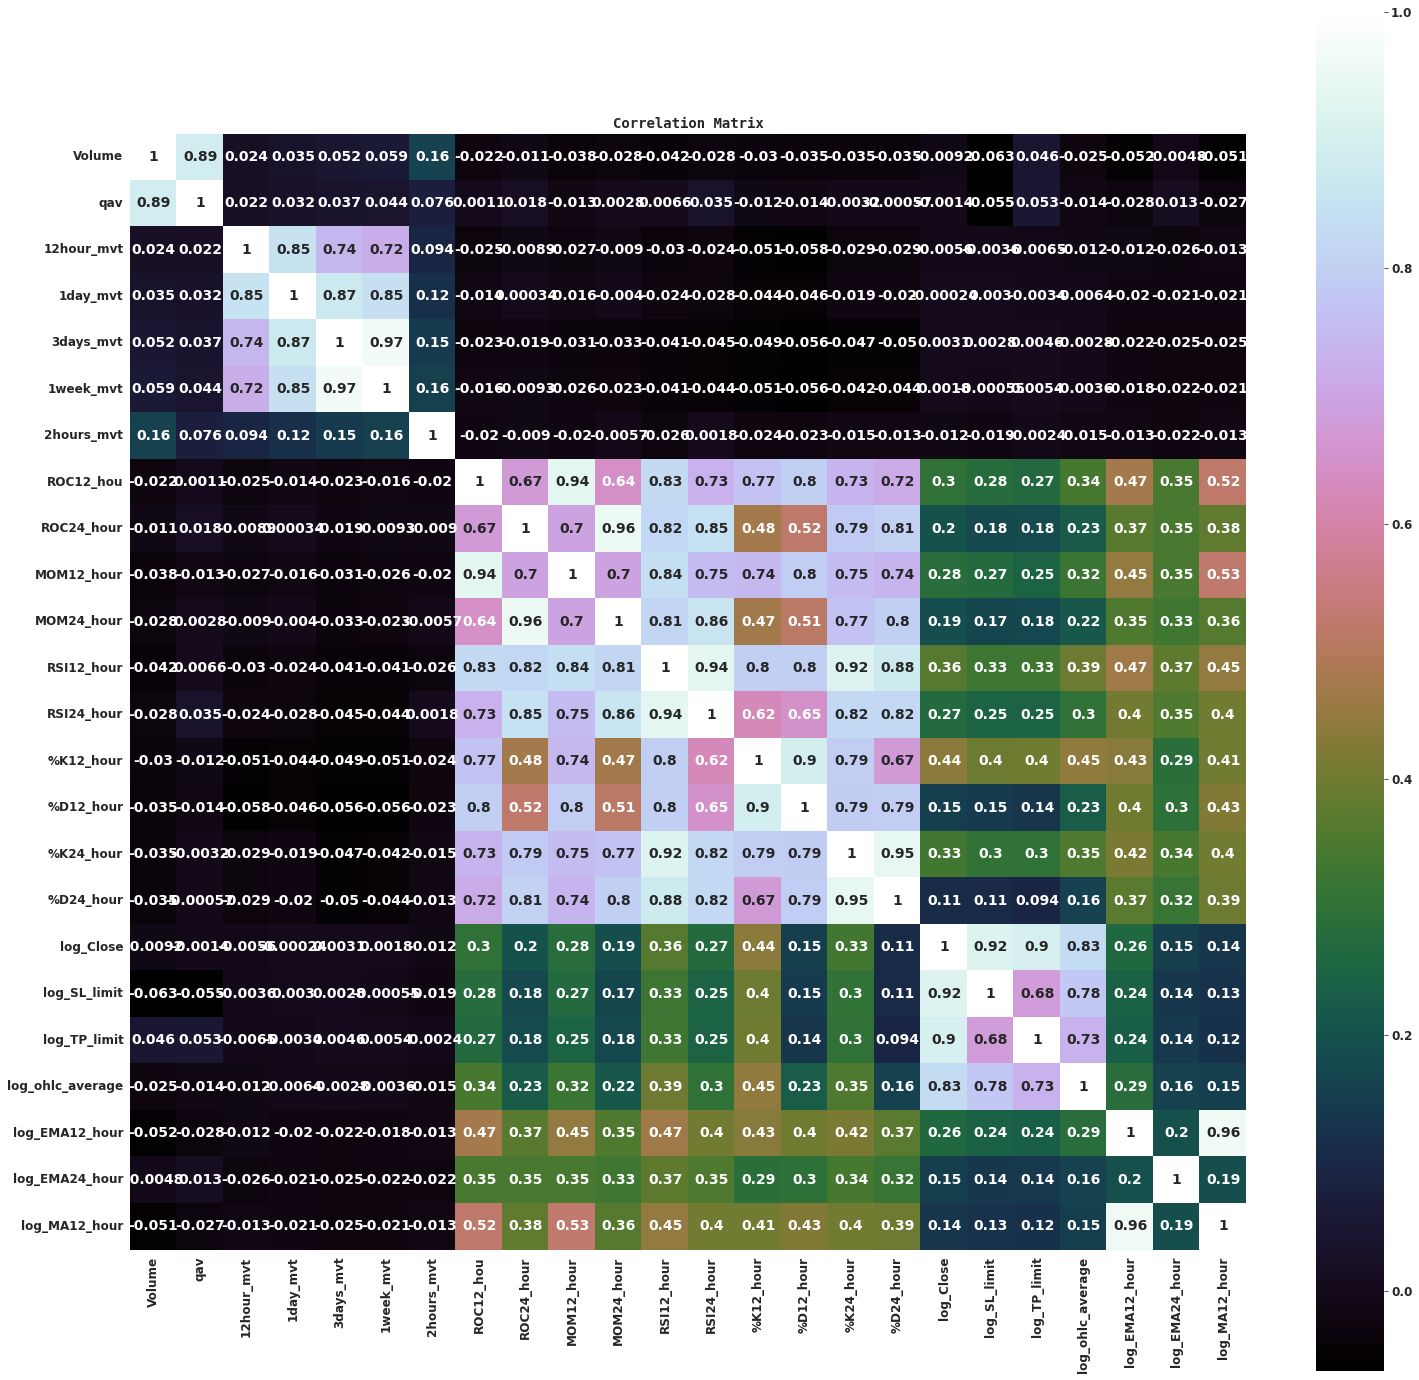

In [43]:
# correlation
correlation = df.corr()
plt.figure(figsize=(25,25))
plt.title('Correlation Matrix',fontdict=font)
sns.heatmap(correlation, vmax=1, square=True,annot=True,cmap='cubehelix')

(array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16,
        17, 18, 19, 20, 21, 22, 23]),
 <a list of 24 Text major ticklabel objects>)

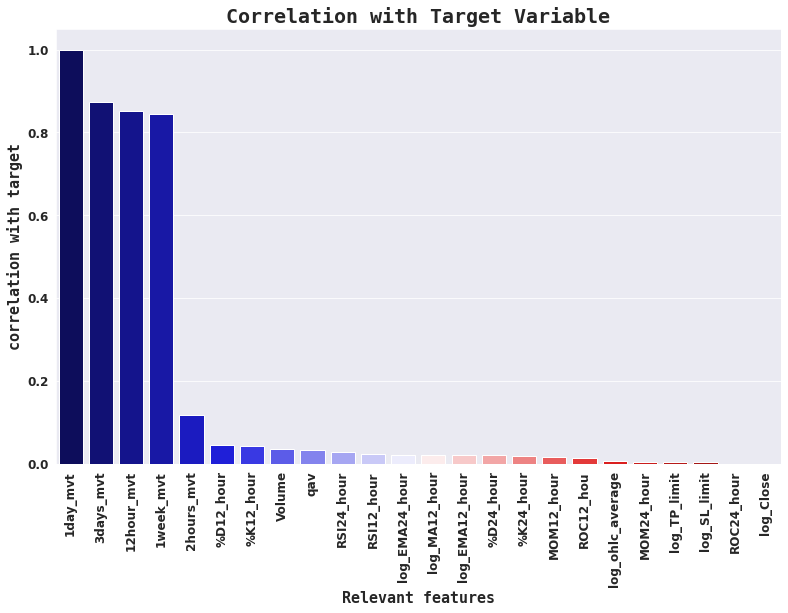

In [44]:
correlation_with_target = abs(correlation['1day_mvt'])
data2=pd.DataFrame(correlation_with_target.sort_values(ascending=False)).reset_index().rename(
    columns ={'index':'Relevant features','1day_mvt':'correlation with target'})
plt.rcParams['figure.figsize'] = (13, 8)
ax = sns.barplot(x = 'Relevant features', y ='correlation with target' , data = data2, palette = 'seismic')
ax.set_xlabel(xlabel = 'Relevant features', fontsize = 15,fontdict=font)
ax.set_ylabel(ylabel = 'correlation with target', fontsize = 15,fontdict=font)
ax.set_title(label = 'Correlation with Target Variable', fontsize = 20,fontdict=font)
plt.xticks(rotation=90)

### **Imbalance between three classes in Targets**

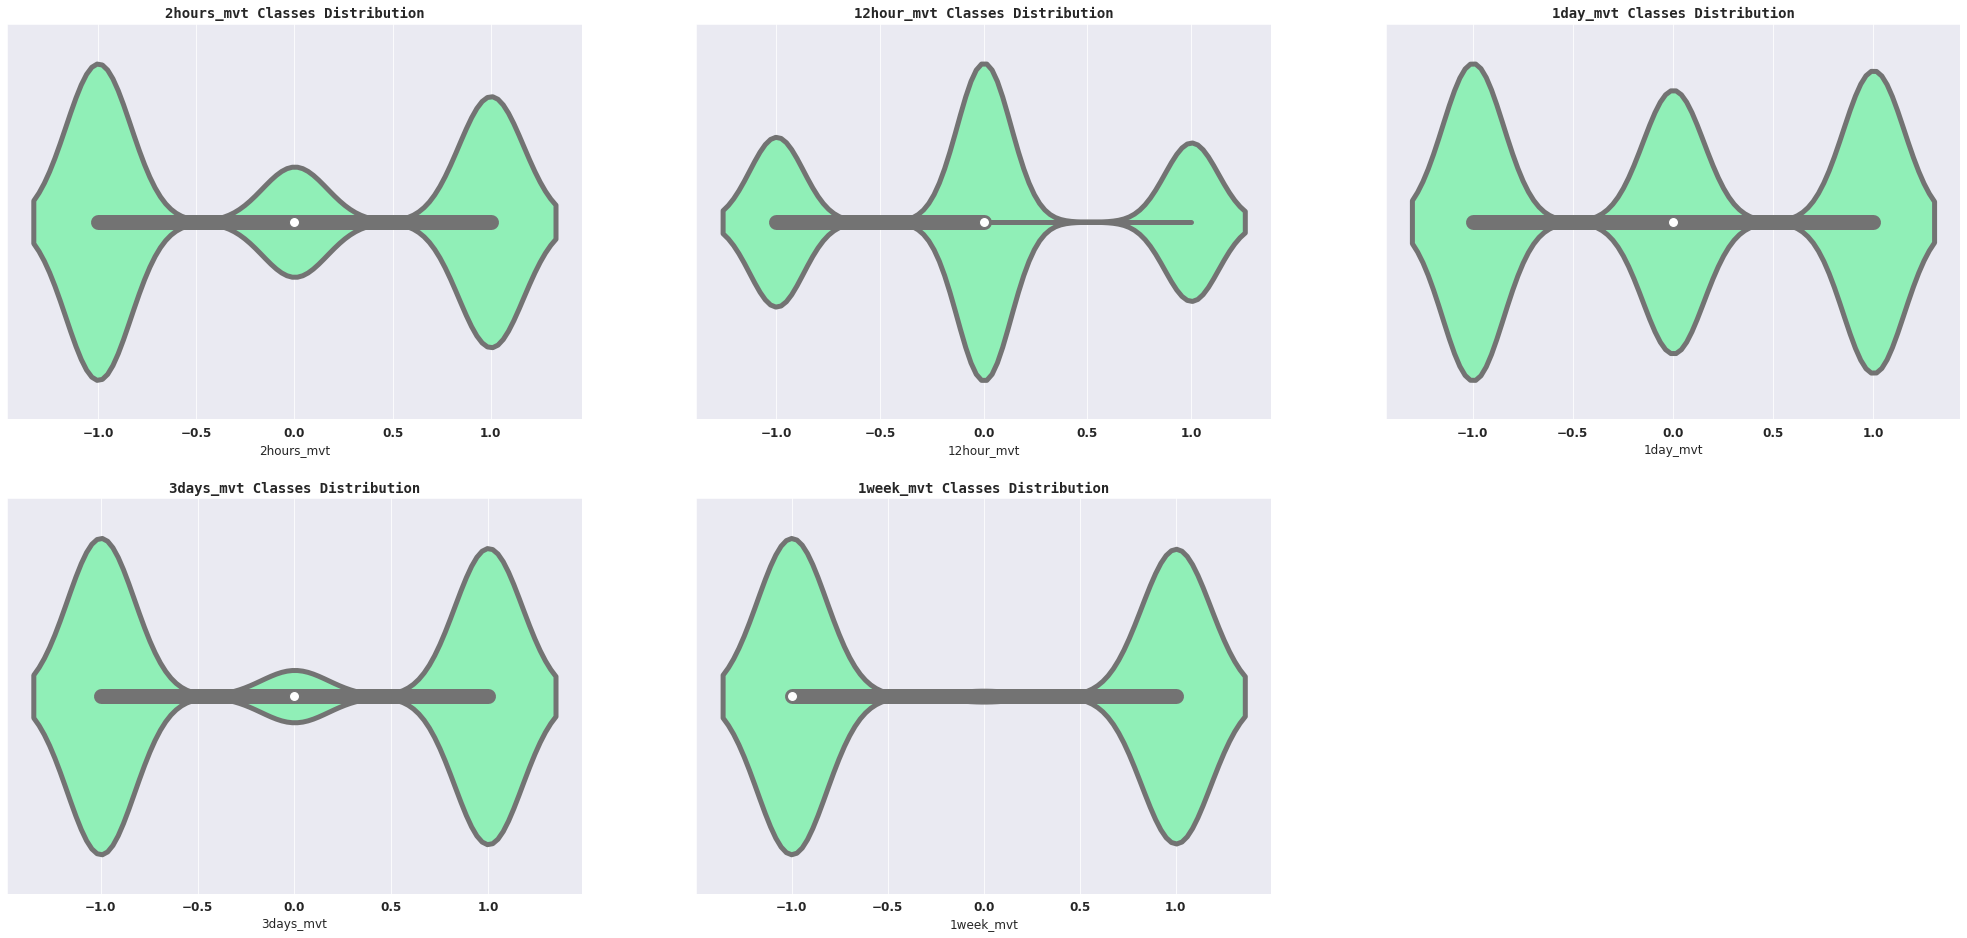

In [45]:
def plot_class_distrib(df,col):
  sns.violinplot(df[col],palette='rainbow',data=df)
  plt.title(col +' Classes Distribution',fontdict=font,fontsize=14)

plt.rcParams['figure.figsize'] = (35,16)

targets=['2hours_mvt','12hour_mvt','1day_mvt','3days_mvt','1week_mvt']
for col in targets:
  plt.subplot(2,3,targets.index(col)+1)
  plot_class_distrib(df,col)

## **Modeling**

In [46]:
def split_train_test(df,target_col):
 cols=df.columns.tolist()
 X=df[[col for col in cols if not(col in targets)]]
 y=df[target_col] 
 from sklearn.model_selection import train_test_split
 X_train,X_test,y_train,y_test=train_test_split(X,y,test_size=0.2,random_state=42,stratify=df[target_col])
 return X_train,X_test,y_train,y_test 

In [47]:
def rebalance_class(df,X_train,y_train):
 from imblearn.over_sampling import SMOTE
 smote=SMOTE('minority')
 X_train,y_train=smote.fit_resample(X_train,y_train)
 return X_train,y_train

In [48]:
# test options for classification
num_folds = 10
seed = 7
#scoring = 'accuracy'
#scoring ='precision'
#scoring ='recall'
#scoring = 'roc_auc'

In [49]:
# spot check the algorithms
def all_models_results(X_train,y_train,metric):
 models = []
 models.append(('LR', LogisticRegression(multi_class='multinomial',random_state=42,n_jobs=-1)))
 models.append(('LDA', LinearDiscriminantAnalysis()))
 models.append(('KNN', KNeighborsClassifier()))
 models.append(('NB', GaussianNB()))
#Neural Network
 models.append(('NN', MLPClassifier()))
#Ensable Models 
# Boosting methods
 models.append(('AdB', AdaBoostClassifier()))
 models.append(('GBM', GradientBoostingClassifier()))
 models.append(('XGBoost', xgboost.XGBClassifier(random_state=42)))
 models.append(('LightGBM',lgb.LGBMClassifier()))
# Bagging methods
 models.append(('RF', RandomForestClassifier(n_jobs=-1)))
 models.append(('ET', ExtraTreesClassifier()))

 names = []
 kfoldresults = []
 list1=[]
 list2=[]
 from sklearn.metrics import f1_score

 for name, model in models:

   #cross validation results
    kfold = KFold(n_splits=num_folds)
    cv_results = cross_val_score(model, X_train, y_train, cv=kfold, scoring=metric,error_score="raise")
    kfoldresults.append(cv_results)
    names.append(name)
    list1.append(cv_results.mean())
    list2.append(cv_results.std())

 # dataframe of cv results   
 dts = pd.DataFrame(list(zip(names,list1,list2)),
               columns =['Models', 'cv_score','cv_std'])   
 
 return dts,kfoldresults,names

In [50]:
def plot_models_results(results,names):
 fig = pyplot.figure()
 fig.suptitle('Algorithm Comparison:Kfolds',fontdict=font)
 ax = fig.add_subplot(111)
 pyplot.boxplot(results)
 ax.set_xticklabels(names)
 fig.set_size_inches(15,8)
 pyplot.show()

## **Targets to predict:**
## **2hours,12hours(Short horizon's prediction) & one_week(longer horizon's prediction)**

In [51]:
X_train,X_test,y_train,y_test=split_train_test(df,'2hours_mvt')
X_train,y_train=rebalance_class(df,X_train,y_train)
X_train,y_train=rebalance_class(df,X_train,y_train) 

In [52]:
df_2,kfoldresults,names=all_models_results(X_train,y_train,'accuracy')
df_2 

,Models,cv_score,cv_std
0,LR,0.264522,0.163725
1,LDA,0.398539,0.084274
2,KNN,0.442949,0.037301
3,NB,0.330228,0.070501
4,NN,0.356294,0.209595
5,AdB,0.427263,0.061246
6,GBM,0.522263,0.030026
7,XGBoost,0.502595,0.040323
8,LightGBM,0.604038,0.020377
9,RF,0.630489,0.027758


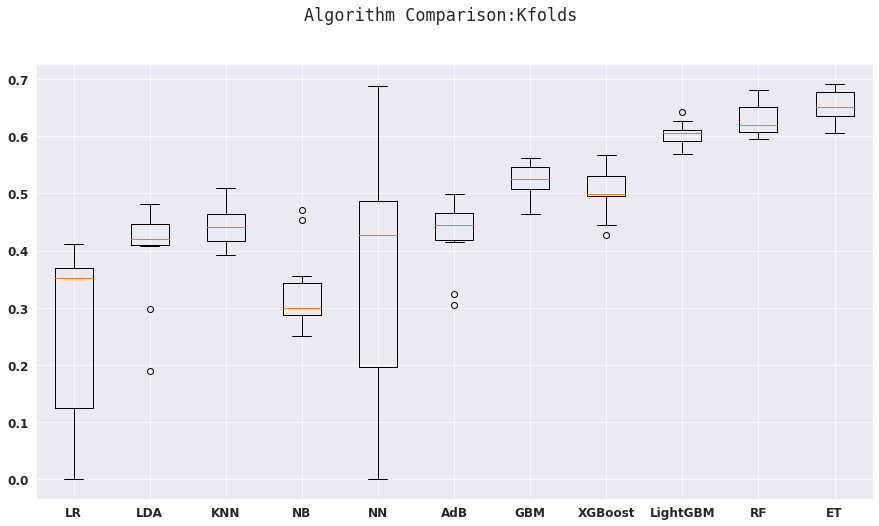

In [53]:
plot_models_results(kfoldresults,names) 

In [54]:
X_train,X_test,y_train,y_test=split_train_test(df,'12hour_mvt')
X_train,y_train=rebalance_class(df,X_train,y_train)
X_train,y_train=rebalance_class(df,X_train,y_train)

In [55]:
df_3,kfoldresults,names=all_models_results(X_train,y_train,'accuracy')
df_3 

,Models,cv_score,cv_std
0,LR,0.189604,0.131760
1,LDA,0.295432,0.141107
2,KNN,0.426796,0.061198
3,NB,0.321704,0.166615
4,NN,0.312468,0.186407
5,AdB,0.427521,0.140571
6,GBM,0.490109,0.125226
7,XGBoost,0.466150,0.155485
8,LightGBM,0.585731,0.077770
9,RF,0.631653,0.047658


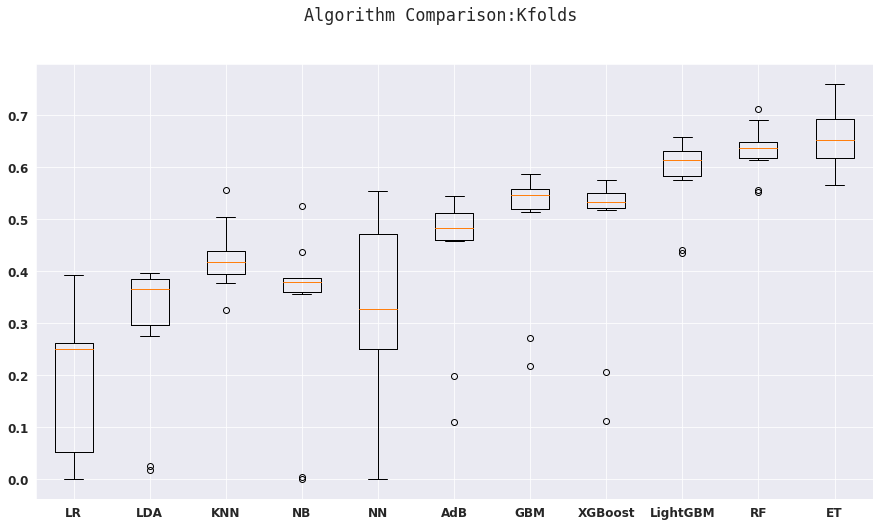

In [56]:
plot_models_results(kfoldresults,names) 

In [57]:
X_train,X_test,y_train,y_test=split_train_test(df,'1week_mvt')
X_train,y_train=rebalance_class(df,X_train,y_train)
X_train,y_train=rebalance_class(df,X_train,y_train)

In [58]:
df_4,kfoldresults,names=all_models_results(X_train,y_train,'accuracy')
df_4 

,Models,cv_score,cv_std
0,LR,0.075675,0.142180
1,LDA,0.466815,0.041377
2,KNN,0.426111,0.051497
3,NB,0.469034,0.032744
4,NN,0.219971,0.223495
5,AdB,0.557683,0.114295
6,GBM,0.634642,0.131312
7,XGBoost,0.614680,0.128575
8,LightGBM,0.707129,0.153795
9,RF,0.706972,0.159503


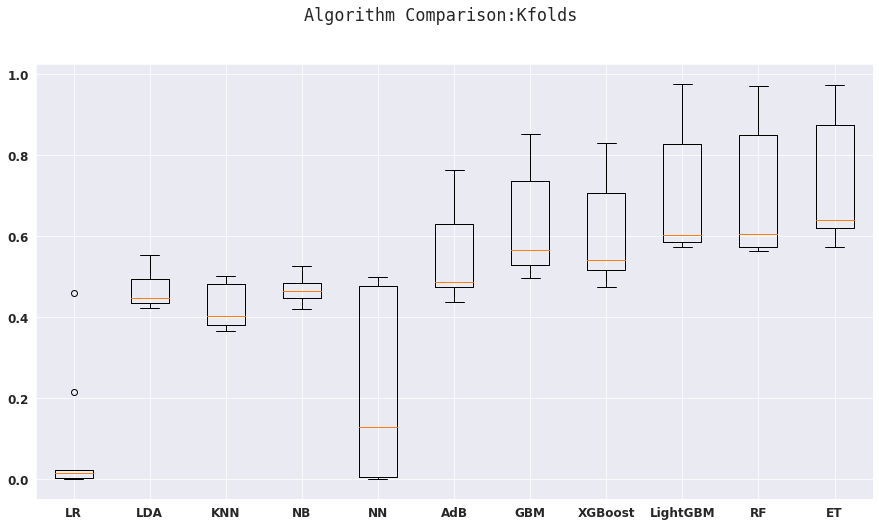

In [59]:
plot_models_results(kfoldresults,names)  

---> **Results are better using this optimised approach which is obviously logic since we have done better work in EDA and Feature engineering and Removing outliers & Adding financial indicators as new features etc...**

## **Hyperparameter Tuning for best promosing models: target=2hour_mouvement**

In [60]:
X_train,X_test,y_train,y_test=split_train_test(df,'2hours_mvt')
X_train,y_train=rebalance_class(df,X_train,y_train)
X_train,y_train=rebalance_class(df,X_train,y_train)


In [61]:
#KNN 
from sklearn.model_selection import GridSearchCV
grid_params = { 'n_neighbors' : [5,7,9,11,13,15],
               'weights' : ['uniform','distance'],
               'metric' : ['minkowski','euclidean','manhattan']}
gs = GridSearchCV(KNeighborsClassifier(), grid_params, verbose = 1, cv=10, n_jobs = -1)

g_res = gs.fit(X_train, y_train)

print(g_res.best_score_)

print(g_res.best_params_)

Fitting 10 folds for each of 36 candidates, totalling 360 fits
0.47775246174822
{'metric': 'manhattan', 'n_neighbors': 15, 'weights': 'distance'}


In [62]:
#Decision Tree
params = {
    'max_depth': [2, 3, 5, 15, 20,25,30],
    'min_samples_leaf': [1,2,3,5,6,7,10],
    'criterion': ["gini", "entropy"]
}

grid_search = GridSearchCV(estimator=DecisionTreeClassifier(), 
                           param_grid=params, 
                           cv=10, n_jobs=-1, verbose=1, scoring = "accuracy")
g_res = grid_search.fit(X_train, y_train)

print(g_res.best_score_)

print(g_res.best_params_) 

Fitting 10 folds for each of 98 candidates, totalling 980 fits
0.5560212089077412
{'criterion': 'gini', 'max_depth': 30, 'min_samples_leaf': 1}


In [63]:
#ExtraTreesClassifier()
gsc = GridSearchCV(
    estimator=ExtraTreesClassifier(),
    param_grid={
        'n_estimators': range(100,170,5),
        'min_samples_leaf': range(0,20,2),
    },
    scoring='accuracy',
    cv=5
)

grid_result = gsc.fit(X_train, y_train) 

print("Best: %f using %s" % (grid_result.best_score_, grid_result.best_params_))

Best: 0.667541 using {'min_samples_leaf': 2, 'n_estimators': 150}


In [64]:
#Random Forest 
n_estimators = [100,150,200,250]
max_depth= [15,10,13,17]
criterion = ["gini","entropy"]
param_grid = dict(n_estimators=n_estimators, max_depth=max_depth, criterion = criterion )
model = RandomForestClassifier(n_jobs=-1)
kfold = KFold(n_splits=num_folds)
grid = GridSearchCV(estimator=model, param_grid=param_grid, scoring="accuracy", cv=kfold)
grid_result = grid.fit(X_train, y_train)

#Print Results : 
print("Best: %f using %s" % (grid_result.best_score_, grid_result.best_params_))
means = grid_result.cv_results_['mean_test_score']
stds = grid_result.cv_results_['std_test_score']
params = grid_result.cv_results_['params']
ranks = grid_result.cv_results_['rank_test_score']
for mean, stdev, param, rank in zip(means, stds, params, ranks):
    print("#%d %f (%f) with: %r" % (rank, mean, stdev, param))


Best: 0.611518 using {'criterion': 'gini', 'max_depth': 17, 'n_estimators': 150}
#16 0.587161 (0.018406) with: {'criterion': 'gini', 'max_depth': 15, 'n_estimators': 100}
#15 0.590815 (0.021585) with: {'criterion': 'gini', 'max_depth': 15, 'n_estimators': 150}
#14 0.591686 (0.014522) with: {'criterion': 'gini', 'max_depth': 15, 'n_estimators': 200}
#13 0.592903 (0.011080) with: {'criterion': 'gini', 'max_depth': 15, 'n_estimators': 250}
#32 0.514773 (0.034996) with: {'criterion': 'gini', 'max_depth': 10, 'n_estimators': 100}
#28 0.522769 (0.044089) with: {'criterion': 'gini', 'max_depth': 10, 'n_estimators': 150}
#25 0.525553 (0.043250) with: {'criterion': 'gini', 'max_depth': 10, 'n_estimators': 200}
#26 0.525382 (0.036907) with: {'criterion': 'gini', 'max_depth': 10, 'n_estimators': 250}
#23 0.572194 (0.013148) with: {'criterion': 'gini', 'max_depth': 13, 'n_estimators': 100}
#19 0.574802 (0.022262) with: {'criterion': 'gini', 'max_depth': 13, 'n_estimators': 150}
#20 0.574629 (0.015

In [65]:
#XGboost
try:
    import xgboost
except ImportError as ex:
    print("Error: the xgboost library is not installed.")
    xgboost = None


if xgboost is not None:  
    xgb_clf = xgboost.XGBClassifier(random_state=42)
params = {
        'min_child_weight': [2,1,0.8],
        'gamma': [1.25, 1.35, 1.36, 1.3202, 1.3905],
        'subsample': [0.75, 0.7, 0.8],
        'colsample_bytree': [0.77, 0.8, 0.880],
        'max_depth': [ 8.88,9,9.123]
        } 
folds = 3
param_comb = 5
from sklearn.model_selection import StratifiedKFold
from sklearn.model_selection import RandomizedSearchCV

skf = StratifiedKFold(n_splits=folds, shuffle = True, random_state = 1001)

random_search = RandomizedSearchCV(xgb_clf, param_distributions=params, n_iter=param_comb, scoring='accuracy', n_jobs=4, cv=skf.split(X_train,y_train), verbose=3, random_state=1001 )

rs_res=random_search.fit(X_train, y_train)
print(rs_res.best_score_)

print(rs_res.best_params_)        

Fitting 3 folds for each of 5 candidates, totalling 15 fits
0.6315240083507306
{'subsample': 0.7, 'min_child_weight': 2, 'max_depth': 9, 'gamma': 1.35, 'colsample_bytree': 0.88}


## **Voting Regressor with Best Tuned Models**

In [66]:
from sklearn.ensemble import VotingClassifier
voting_clf=VotingClassifier(estimators=[('LGBM',lgb.LGBMClassifier()),
                                        ('RF',RandomForestClassifier(criterion= 'gini', max_depth=17, n_estimators= 200)),
                                        ('ExtraTrees',ExtraTreesClassifier(min_samples_leaf= 2, n_estimators= 165)),
                                        ('xgboost',xgboost.XGBClassifier(subsample=0.7,min_chils_weight=2,max_depth=9,gamma=1.35,colsample_bytree=0.88))
                                      ],voting='hard')
voting_clf.fit(X_train,y_train)  

VotingClassifier(estimators=[('LGBM', LGBMClassifier()),
                             ('RF',
                              RandomForestClassifier(max_depth=17,
                                                     n_estimators=200)),
                             ('ExtraTrees',
                              ExtraTreesClassifier(min_samples_leaf=2,
                                                   n_estimators=165)),
                             ('xgboost',
                              XGBClassifier(colsample_bytree=0.88, gamma=1.35,
                                            max_depth=9, min_chils_weight=2,
                                            subsample=0.7))])

In [67]:
from sklearn.metrics import classification_report
print(classification_report(y_test, voting_clf.predict(X_test)))    #DecisionTreeClassifier()

              precision    recall  f1-score   support

        -1.0       0.63      0.64      0.64       480
         0.0       0.38      0.47      0.42       167
         1.0       0.62      0.55      0.58       380

    accuracy                           0.58      1027
   macro avg       0.54      0.55      0.55      1027
weighted avg       0.59      0.58      0.58      1027



**We got quite better results since here we are predicting price mouvement in the next two hours which is much harder then predicting it in three days as we did in the previous notebook**

**Feature Enigineeirng , Moving outilers, adding financial indicators(trend & momentum) make a good work by boosting a lot the accuracy of our models**

[0.08485504 0.08735997 0.05067539 0.05977447 0.04881803 0.05797139
 0.04881857 0.06557445 0.04769367 0.0491584  0.04977896 0.05497274
 0.03738259 0.03804173 0.03833546 0.04097116 0.04478814 0.04672894
 0.0483009 ]


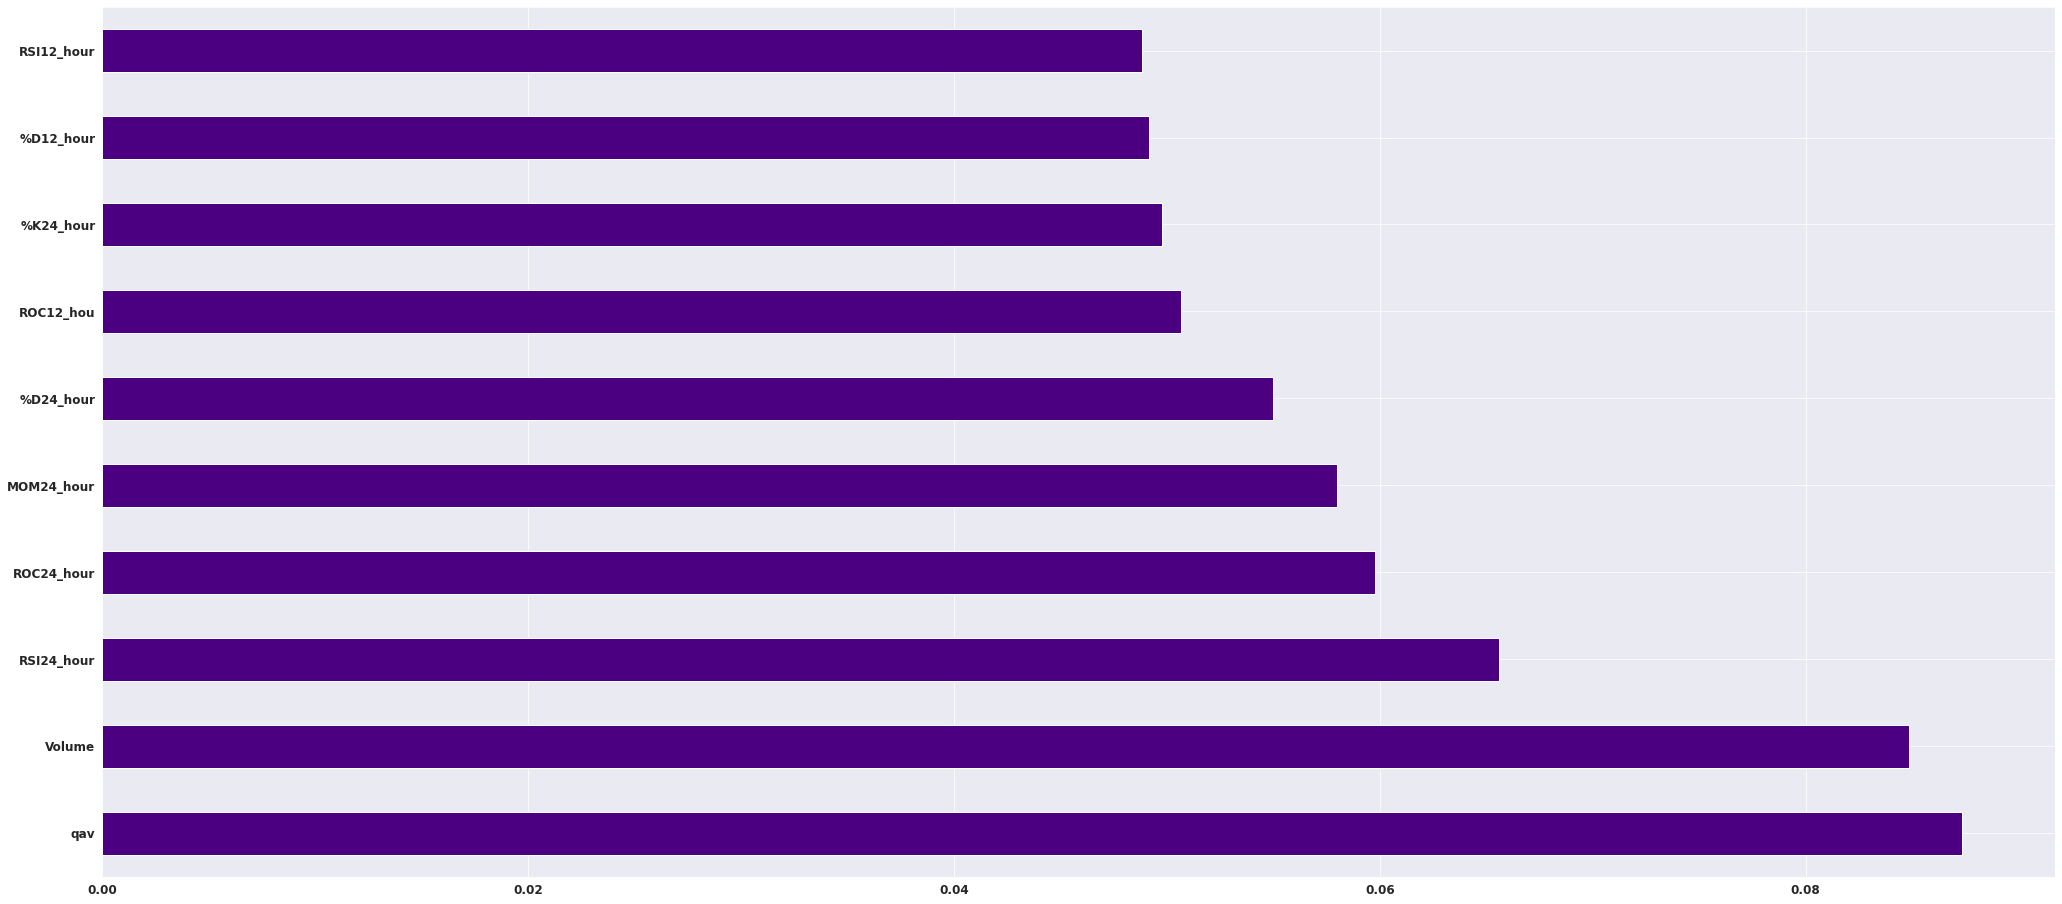

In [68]:
Extra_trees=ExtraTreesClassifier(min_samples_leaf= 2, n_estimators= 135)
Extra_trees.fit(X_train,y_train)
Extra_trees.predict(X_test)
print(Extra_trees.feature_importances_) #use inbuilt class feature_importances
feat_importances = pd.Series(Extra_trees.feature_importances_, index=X_train.columns)
#plot graph of feature importances for better visualization
feat_importances.nlargest(10).plot(kind='barh',color='indigo')
pyplot.show()

**We see clearly that are financial momentum indicators features are considered as the most important features for predictions, so our idea to add them to the initial dataset was a good idea**

In [69]:
df.head(2)

,Volume,qav,12hour_mvt,1day_mvt,3days_mvt,1week_mvt,2hours_mvt,ROC12_hou,ROC24_hour,MOM12_hour,...,%D12_hour,%K24_hour,%D24_hour,log_Close,log_SL_limit,log_TP_limit,log_ohlc_average,log_EMA12_hour,log_EMA24_hour,log_MA12_hour
1,3154.434156,1.181736e+08,0.0,0.0,0.0,0.0,0.0,0.059517,0.126009,11.87493,...,51.828507,52.133674,52.134047,0.000025,0.000022,0.000028,0.000023,-0.000023,-0.000023,-0.000023
2,3078.850158,1.135512e+08,0.0,-1.0,-1.0,-1.0,-1.0,0.059517,0.126009,11.87493,...,51.828507,52.133674,52.134047,-0.009363,-0.032724,0.013465,-0.013398,0.000000,0.000000,0.000000


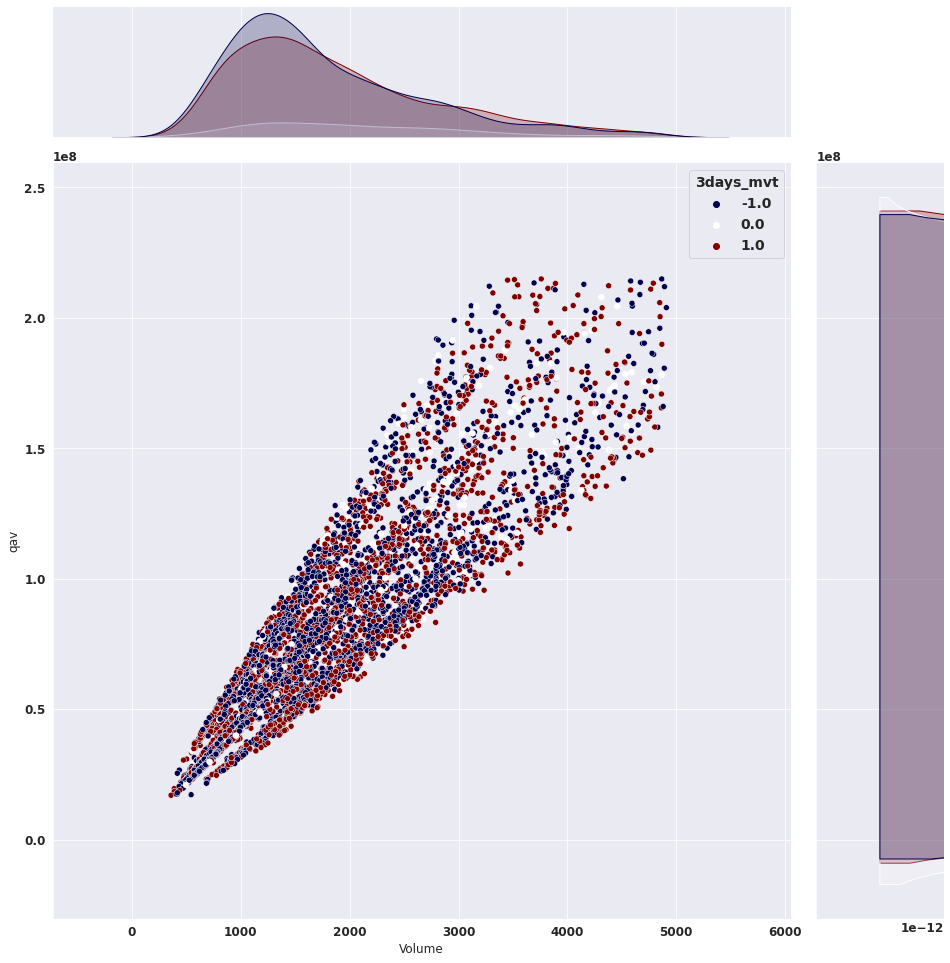

In [80]:
sns.jointplot(x=df['Volume'],y=df['qav'],hue=df['3days_mvt'],data=df,palette='seismic')
fig = plt.gcf()
fig.set_size_inches(15, 15,forward=True)

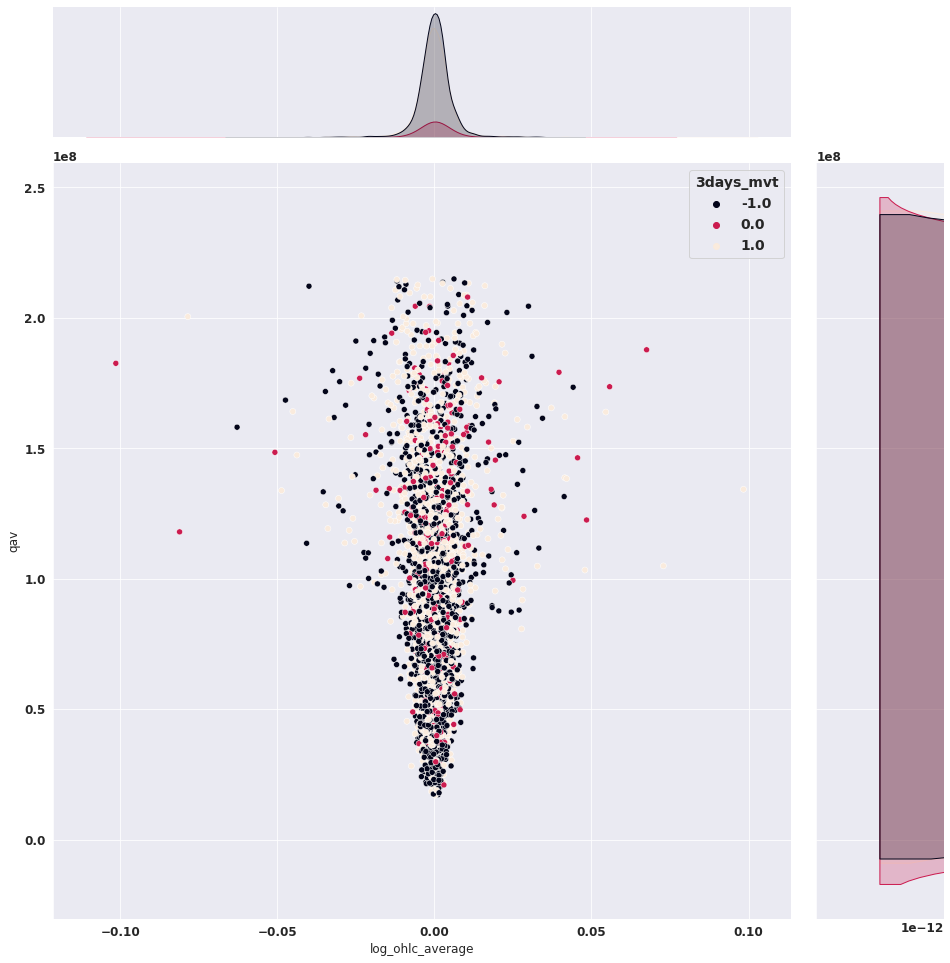

In [94]:
sns.jointplot(x=df['log_ohlc_average'],y=df['qav'],hue=df['3days_mvt'],data=df,palette='rocket')
fig = plt.gcf()
fig.set_size_inches(15, 15,forward=True)

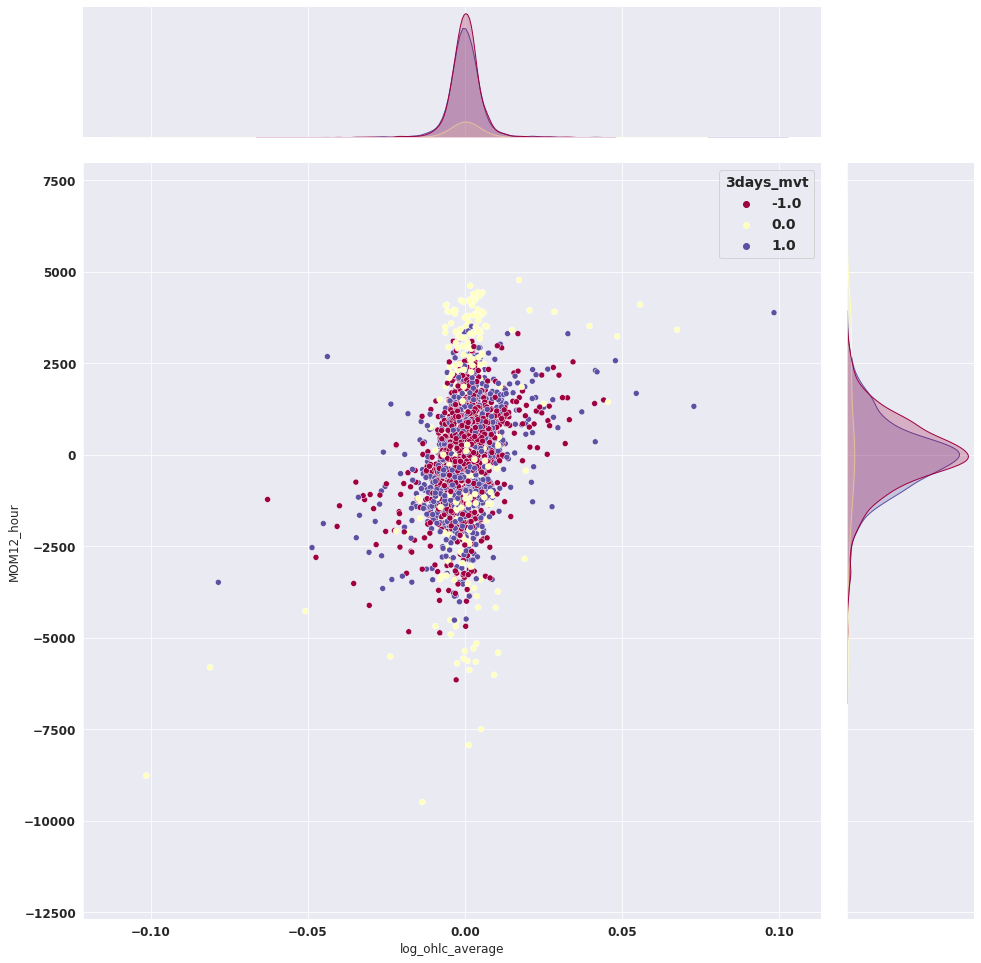

In [93]:
sns.jointplot(x=df['log_ohlc_average'],y=df['MOM12_hour'],hue=df['3days_mvt'],data=df,palette='Spectral')
fig = plt.gcf()
fig.set_size_inches(15, 15,forward=True)

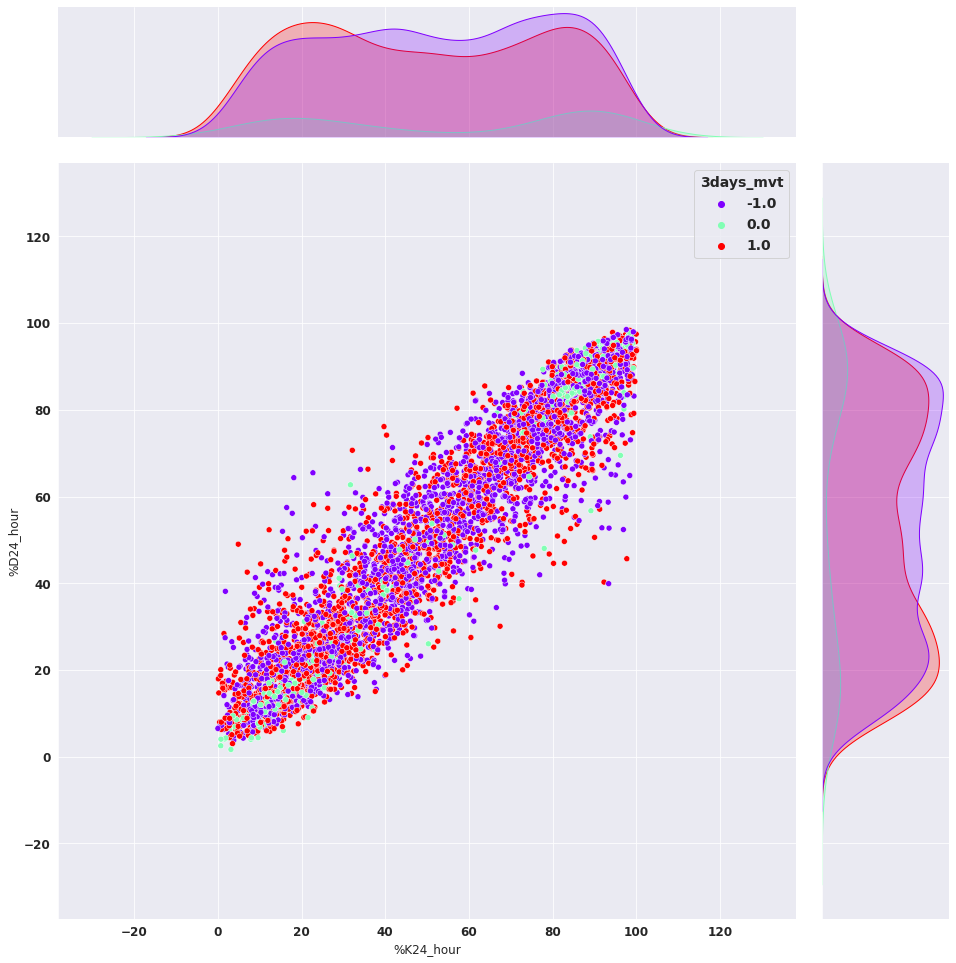

In [92]:
sns.jointplot(x=df['%K24_hour'],y=df['%D24_hour'],hue=df['3days_mvt'],data=df,palette='rainbow')
fig = plt.gcf()
fig.set_size_inches(15, 15,forward=True)

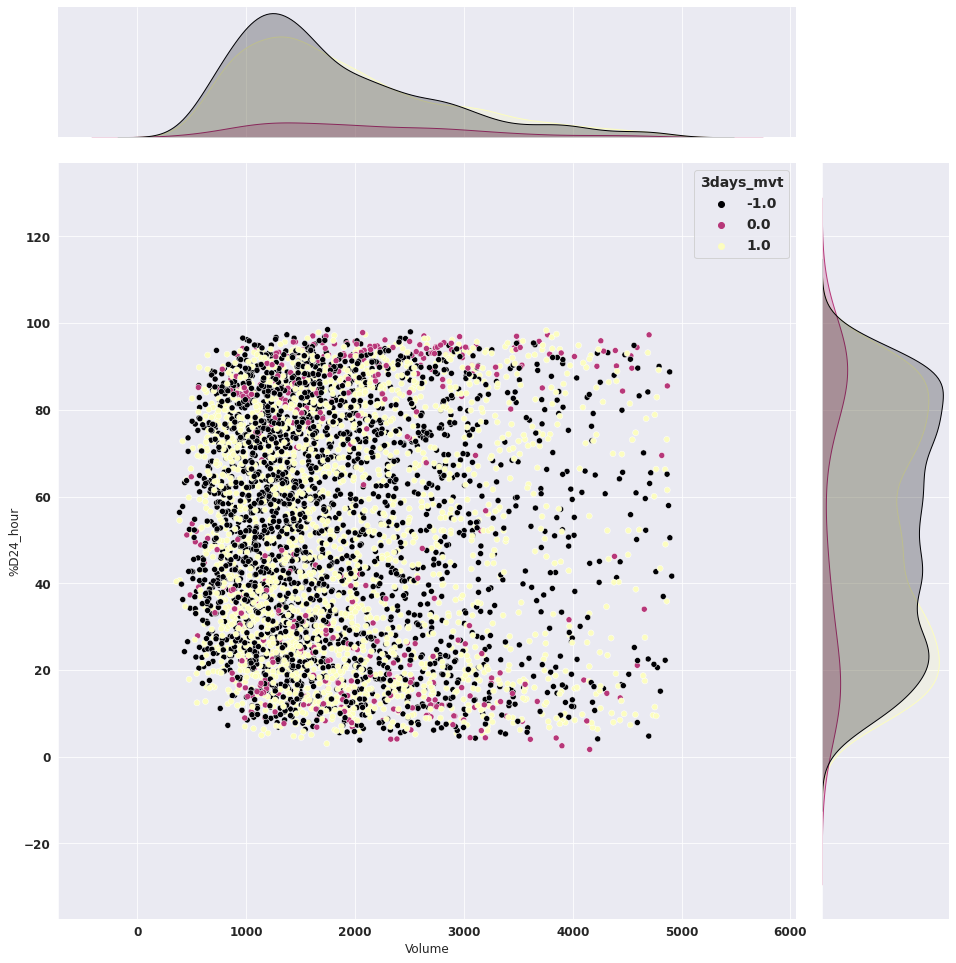

In [91]:
sns.jointplot(x=df['Volume'],y=df['%D24_hour'],hue=df['3days_mvt'],data=df,palette='magma')
fig = plt.gcf()
fig.set_size_inches(15, 15,forward=True) 